# Abstract

In contemporary contexts, machine learning and deep learning algorithms have demonstrated considerable efficacy across diverse domains. Soil moisture, a pivotal parameter in agricultural and water management, poses a challenge for accurate forecasting owing to its multifaceted characteristics and temporal variations. Basic statistical methods often prove inadequate for precise predictions in this context. This study endeavors to address the prediction of soil moisture levels as a regression and time-dependent problem within the realm of machine learning.

The primary objective involves the implementation of various machine learning techniques, including the Huber Regressor, Random Forest Regressor, Support Vector Regressor (SVR), and a deep learning approach utilizing Long Short-Term Memory (LSTM) networks. The goal is to forecast the soil moisture levels on a daily basis for a period extending 30 days into the future. The target variable for prediction is denoted as "BF10," representing soil moisture under grass and sandy loam between 0 and 10 cm depth, expressed as a percentage of plant-usable water (%nFK).

The dataset comprises several attributes to leverage for prediction, each serving a specific purpose:

1- DATUM: The datetime column.

2- STATIONS_ID: DWD weather station ID.

3- QN_4: Quality level of TT_TER and RF_TER columns, categorized based on control and correction procedures.

4- TT_TER: Air temperature.

5- RF_TER: Relative humidity.

6- VGSL: Real evapotranspiration over grass and sandy loam (mm).

7- TS05: Mean daily soil temperature at a 5 cm depth for uncovered typical soil (°C).

8- BF10: Target variable – soil moisture between 0 and 10 cm depth in % plant-usable water (%nFK).

To enhance prediction accuracy, the dataset undergoes a series of preprocessing steps, encompassing:

1- Data Reading and Initial Processing: Structuring the dataset to a daily basis and ensuring correct data types for features.

2- Exploratory Data Analysis (EDA): Examining null values, unique values per feature, descriptive statistics, and identifying potential anomalies.

3- Data Preparation: Aligning the data with insights derived from EDA.

4- Feature Selection and Engineering: Identifying informative features and selecting appropriate scaling methods for model implementation.

5- Machine Learning Models Implementation: Preparing, tuning, training, and evaluating the performance of selected machine learning models.

6- LSTM Model Implementation: Applying the same methodology as in Section 5 specifically for the LSTM model.

7- Evaluation and Model Comparison: Dedicated to assessing and comparing the performance of all models in the prediction task.

This systematic approach ensures a comprehensive and rigorous methodology in predicting soil moisture levels, with due consideration to both traditional machine learning models and advanced deep learning techniques.

# 1- ***Data Reading and Initial Processing***

In [586]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from random import sample

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, learning_curve
from sklearn.linear_model import Lasso, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import backend as be
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1


In [594]:
# Read the dataframe in pandas format
df = pd.read_csv('soil_moisture.csv')
df.head()

,DATUM,STATIONS_ID,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
0,1991-01-01 07:00:00,1766,10,3.0,91.0,0.3,2.9,102
1,1991-01-01 14:00:00,1766,10,4.8,85.0,0.3,2.9,102
2,1991-01-01 21:00:00,1766,10,3.9,82.0,0.3,2.9,102
3,1991-01-02 07:00:00,1766,10,5.6,94.0,1.4,6.3,110
4,1991-01-02 14:00:00,1766,10,11.0,87.0,1.4,6.3,110


The dataset under consideration comprises 8 columns and encompasses a total of 35,672 samples, wherein one column assumes an object data type, while the remaining seven columns are of a numerical nature. The column rendered in object format pertains to temporal information encapsulated within dates, necessitating specialized handling.

Upon preliminary inspection, the dataset exhibits a notable absence of missing values, affirming its completeness and data integrity. To facilitate subsequent analytical procedures and model implementation, the date column, initially formatted as an object, undergoes a judicious conversion to a standardized date format. This conversion is a critical preprocessing step aimed at imbuing the temporal data with a structured and standardized representation, thereby facilitating seamless integration into analytical frameworks and ensuring consistency in subsequent analyses.

In [595]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATUM        35672 non-null  object 
 1   STATIONS_ID  35672 non-null  int64  
 2   QN_4         35672 non-null  int64  
 3   TT_TER       35672 non-null  float64
 4   RF_TER       35672 non-null  float64
 5   VGSL         35672 non-null  float64
 6   TS05         35672 non-null  float64
 7   BF10         35672 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 2.2+ MB


In [596]:
# Extract the column names with number type
num_columns = df.select_dtypes(np.number).columns.to_list()

# Extract the column names with object type
object_columns = df.select_dtypes(object).columns.to_list()

# print the result
print(f'columns that have numercal types are =>{num_columns} \n\
columns that have object types are =>{object_columns}')

columns that have numercal types are =>['STATIONS_ID', 'QN_4', 'TT_TER', 'RF_TER', 'VGSL', 'TS05', 'BF10'] 
columns that have object types are =>['DATUM']


In [597]:
# Convert Date column type to datetime type
df['DATUM'] = pd.to_datetime(df['DATUM'])
df.dtypes

DATUM          datetime64[ns]
STATIONS_ID             int64
QN_4                    int64
TT_TER                float64
RF_TER                float64
VGSL                  float64
TS05                  float64
BF10                    int64
dtype: object

The temporal aspect of the dataset introduces a nuanced complexity, as the date information is recorded on an hourly basis. However, it is imperative to note that the recording intervals fluctuate both in terms of the number of recordings and the time of recording across different days. A discerning examination, as delineated by the provided codes, reveals a temporal inconsistency in the data acquisition process. For instance, the initial 20 records showcase recordings at 7 AM, 2 PM, and 9 PM, whereas the subsequent 20 records exhibit data acquisition at 12 AM, 6 AM, 12 PM, and 6 PM. This variance extends to the number of measurements on distinct days, with certain days featuring 3, others 4, and yet others only 1 measurement.

In order to rectify this temporal incongruity and align with the primary objective of predicting soil moisture on a daily basis, a meticulous resampling of the dataframe is undertaken. This involves aggregating the measurements for each feature on a daily scale by computing the mean of measurements recorded within a given day. This resampling strategy not only harmonizes the temporal granularity but also establishes a consistent daily framework for subsequent predictive modeling endeavors.https://www.geeksforgeeks.org/how-to-group-pandas-dataframe-by-date-and-time/

A secondary aspect of the data refinement process involves a comprehensive verification of the continuity of the date sequence. Ensuring the uninterrupted sequence of dates is paramount for accurate time-series analyses. Concurrently, a rigorous assessment is conducted to identify and rectify potential gaps or missing dates within the temporal progression. This meticulous examination serves to fortify the dataset's temporal integrity, an indispensable prerequisite for reliable and robust predictive modeling in the domain of soil moisture forecasting.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html

In [598]:
# Display the time of 20 first recorded data. 
df.loc[0:19,'DATUM']

0    1991-01-01 07:00:00
1    1991-01-01 14:00:00
2    1991-01-01 21:00:00
3    1991-01-02 07:00:00
4    1991-01-02 14:00:00
5    1991-01-02 21:00:00
6    1991-01-03 07:00:00
7    1991-01-03 14:00:00
8    1991-01-03 21:00:00
9    1991-01-04 07:00:00
10   1991-01-04 14:00:00
11   1991-01-04 21:00:00
12   1991-01-05 07:00:00
13   1991-01-05 14:00:00
14   1991-01-05 21:00:00
15   1991-01-06 07:00:00
16   1991-01-06 14:00:00
17   1991-01-06 21:00:00
18   1991-01-07 07:00:00
19   1991-01-07 14:00:00
Name: DATUM, dtype: datetime64[ns]

In [599]:
# Display the time of 20 last recorded data. 
df['DATUM'].iloc[-21:-1]

35651   2021-12-26 00:00:00
35652   2021-12-26 06:00:00
35653   2021-12-26 12:00:00
35654   2021-12-26 18:00:00
35655   2021-12-27 00:00:00
35656   2021-12-27 06:00:00
35657   2021-12-27 12:00:00
35658   2021-12-27 18:00:00
35659   2021-12-28 00:00:00
35660   2021-12-28 06:00:00
35661   2021-12-28 12:00:00
35662   2021-12-28 18:00:00
35663   2021-12-29 00:00:00
35664   2021-12-29 06:00:00
35665   2021-12-29 12:00:00
35666   2021-12-29 18:00:00
35667   2021-12-30 00:00:00
35668   2021-12-30 06:00:00
35669   2021-12-30 12:00:00
35670   2021-12-30 18:00:00
Name: DATUM, dtype: datetime64[ns]

In [600]:
# Creat a serie with the length of dataframe and indexes equals to the DATUM column
new_serie = pd.Series(range(len(df)), index = df['DATUM'])

# Group the serie by day 
groupby_day = new_serie.groupby(pd.Grouper(axis='rows', freq='D'))

# Build a list, containing the number of measurements in each day
num_hours = list()
for day, hours in groupby_day:
    num_hours.append(len(hours))

# Covert the num_hours list to numpy array and display the unique number of measurments in different days
num_hours = np.array(num_hours)
np.unique(num_hours)    



array([1, 3, 4])

In [601]:
# Set the date column as the index of dataframe
df.set_index('DATUM', inplace=True)
df

,STATIONS_ID,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
DATUM,,,,,,,
1991-01-01 07:00:00,1766,10,3.0,91.0,0.3,2.9,102
1991-01-01 14:00:00,1766,10,4.8,85.0,0.3,2.9,102
1991-01-01 21:00:00,1766,10,3.9,82.0,0.3,2.9,102
1991-01-02 07:00:00,1766,10,5.6,94.0,1.4,6.3,110
1991-01-02 14:00:00,1766,10,11.0,87.0,1.4,6.3,110
...,...,...,...,...,...,...,...
2021-12-30 00:00:00,1766,1,11.6,90.0,0.8,9.4,104
2021-12-30 06:00:00,1766,1,11.1,98.0,0.8,9.4,104
2021-12-30 12:00:00,1766,1,14.3,83.0,0.8,9.4,104


In [602]:
# Resample data on a daily basis and on the mean of measurments 
daily_df = df.resample('D').mean()
daily_df.head(10)

,STATIONS_ID,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
DATUM,,,,,,,
1991-01-01,1766.0,10.0,3.900000,86.000000,0.3,2.9,102.0
1991-01-02,1766.0,10.0,9.200000,90.666667,1.4,6.3,110.0
1991-01-03,1766.0,10.0,7.733333,82.333333,1.0,6.6,110.0
1991-01-04,1766.0,10.0,6.433333,76.666667,1.2,5.5,106.0
1991-01-05,1766.0,10.0,5.466667,78.000000,1.0,3.7,109.0
1991-01-06,1766.0,10.0,6.033333,67.666667,1.1,3.4,103.0
1991-01-07,1766.0,10.0,6.166667,78.000000,0.8,3.9,103.0
1991-01-08,1766.0,10.0,6.600000,79.333333,1.0,4.5,110.0
1991-01-09,1766.0,10.0,7.733333,73.000000,1.8,5.9,107.0


In [603]:
# Extract the start date and the last date of data frame
start_date = daily_df.index[0]
end_date = daily_df.index[-1]
print(f'The starting date of data set is ==>{start_date}\nThe last date of data set is==>{end_date}')

# Create a daily based data range between the first and last date of dataframe
date_range = pd.date_range(start=start_date, end=end_date, inclusive='both', freq='D')

# Checking for equality of dates in dataframe and the data_range
np.unique(daily_df.index == date_range) 

The starting date of data set is ==>1991-01-01 00:00:00
The last date of data set is==>2021-12-31 00:00:00


array([ True])

# 2- ***Exploratory Data Analysis (EDA)***

## 2-1- Explore Statistical Behavior of Dataset
In the pursuit of comprehensively characterizing the dataset, a meticulous exploration of its statistical attributes is undertaken, yielding valuable insights that contribute to the subsequent analytical refinement. The key facets of this exploration are explicated as follows:

- 1- Null Value Assessment:
The initial scrutiny involves a comprehensive examination for the presence of null values within the dataframe. Notably, this dataset emerges as notably complete, devoid of any instances of missing values. This observation augurs well for the overall reliability and robustness of the dataset, setting a solid foundation for subsequent analyses.
- 2- Feature-Specific Unique Value Analysis:
An inquiry into the number of unique values characterizing each feature within the dataset unveils intriguing patterns. Notably, the feature 'STATIONS_ID' manifests a singular value throughout the dataset, signifying uniformity in the origin of all samples from a singular station. Consequently, recognizing the limited variability offered by this feature, it is judicious to exclude it from the dataset during the training and construction of predictive models.
- 3- Analysis of "QN_4" Feature:
The feature denoted as "QN_4," representing the quality level of air temperature and relative humidity columns, undergoes a detailed examination. This feature exhibits a categorical nature with only three distinct values. Specifically, the values "1," "3," and "10" appear in frequencies of 11, 1725, and 9587 instances, respectively. This distribution provides valuable contextual information regarding the quality control procedures applied to the relevant columns.

In light of the insights garnered from the aforementioned analyses, a decision is made to exclude the features "STATIONS_ID" and "QN_4" from the subsequent statistical analysis processes. The rationale behind this exclusion stems from the former's singular value representation and the latter's role as an indicator code for quality control procedures. The resulting refined dataframe, denominated as "to_explore_df," serves as the focal point for further in-depth statistical assessments and forms the basis for subsequent modeling endeavors.

In [604]:
# Count the number of null values in each feature
num_null_value = daily_df.isnull().sum()

# Determine the number of unique values in each feature
num_unique_value = daily_df.nunique()

# Create a summary dataframe combining null and unique value counts
df_summary = pd.concat([num_null_value,num_unique_value], axis='columns', 
                       keys= ['num of nulls', 'num of unique'])
df_summary

,num of nulls,num of unique
STATIONS_ID,0,1
QN_4,0,3
TT_TER,0,2294
RF_TER,0,388
VGSL,0,72
TS05,0,433
BF10,0,112


In [605]:
# Count number of values under QN_4
daily_df['QN_4'].value_counts()

QN_4
10.0    9587
3.0     1725
1.0       11
Name: count, dtype: int64

In [606]:
# Create the to_explore_df dataframe
to_explore_df = daily_df.drop(['STATIONS_ID', 'QN_4'], axis=1)

The initial analysis of the dataset, as encapsulated in the descriptive summary table, initially suggests a semblance of symmetry in the distribution of key features such as "TT_TER," "RF_TER," "VGSL," "TS05," and "BF10." This inference is drawn from the observation that the means and medians of these features exhibit approximate parity. However, a deeper examination, as revealed through pair plot visualizations, dispels this initial impression. Contrary to the apparent symmetry inferred from summary statistics, the pair plots elucidate distinct and divergent behaviors among these features, especially concerning their interactions with the varying levels of the target variable.

In [607]:
# Descriptive anlysis of dataset
to_explore_df.describe()

,TT_TER,RF_TER,VGSL,TS05,BF10
count,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000
mean,10.720296,76.819247,1.241093,11.042303,71.004063
std,7.078653,13.231403,0.980625,7.679070,37.056605
min,-15.533333,-176.500000,0.000000,-8.000000,0.000000
25%,5.533333,68.666667,0.500000,4.600000,41.000000
50%,10.700000,78.750000,1.000000,10.800000,88.000000
75%,16.112500,86.666667,1.800000,17.400000,102.000000
max,30.866667,100.000000,6.300000,29.200000,111.000000


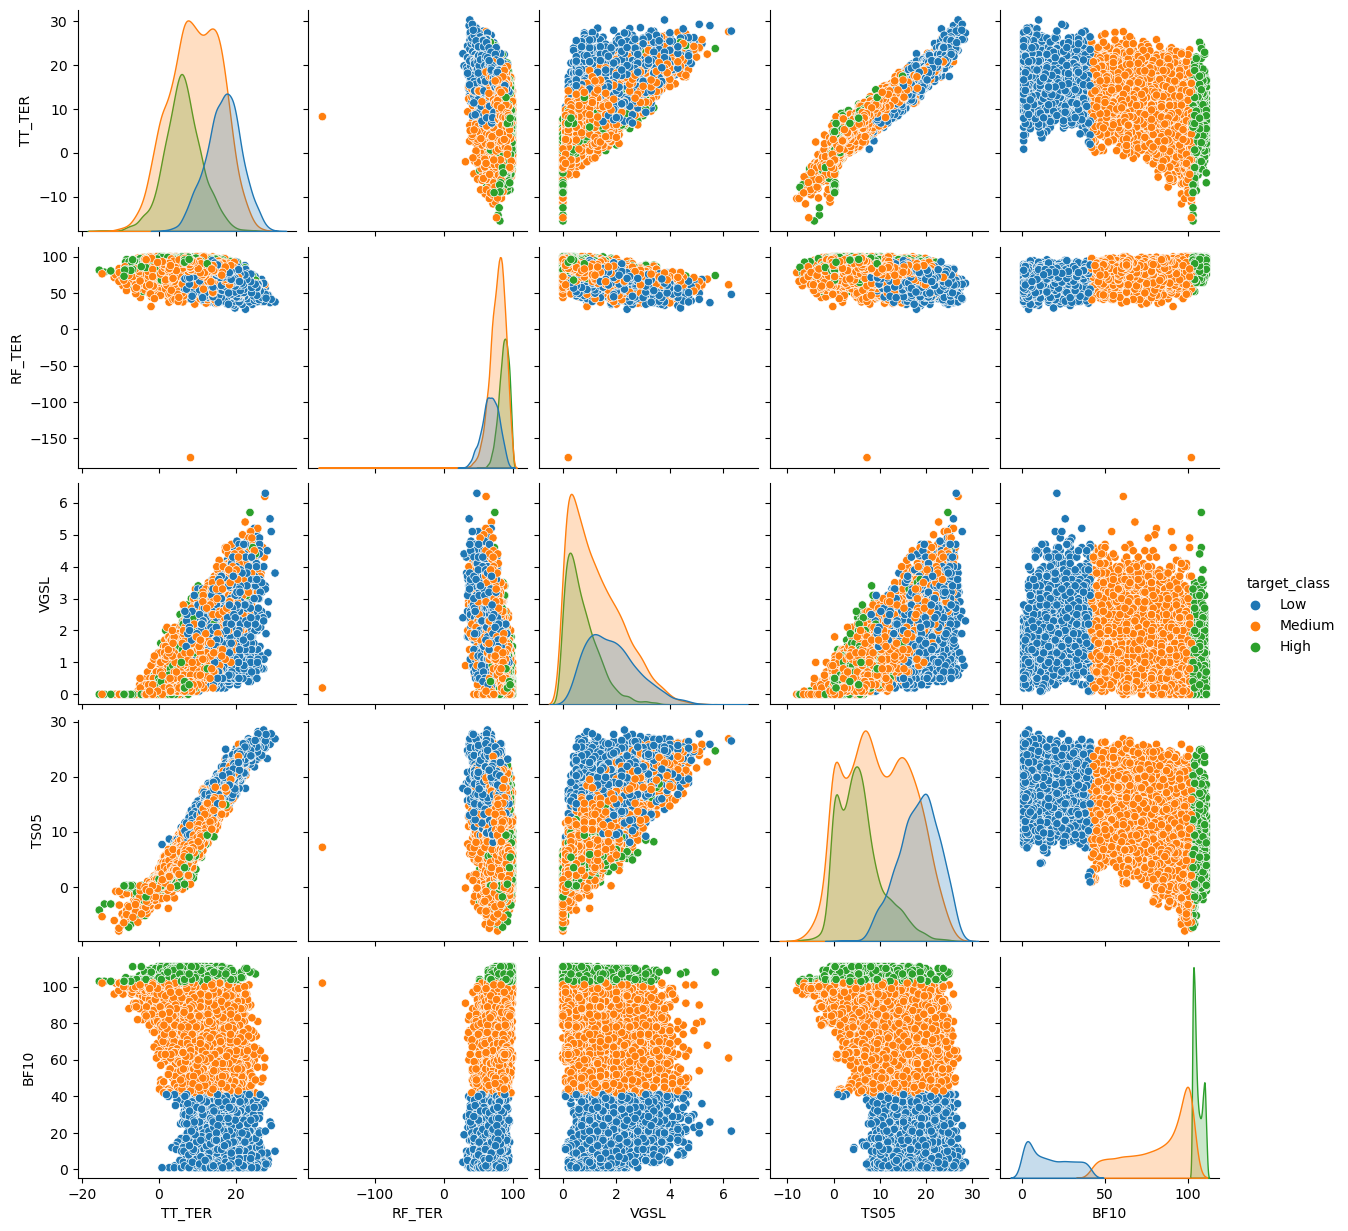

In [608]:
# Determine the thresholds for classifying the target variable
low_threshold = to_explore_df['BF10'].quantile(0.25)
high_threshold = to_explore_df['BF10'].quantile(0.75)

# Create a new categorical variable based on the thresholds
to_explore_df['target_class'] = pd.cut(to_explore_df['BF10'], bins=[to_explore_df['BF10'].min(),
                             low_threshold, high_threshold, to_explore_df['BF10'].max()], 
                             labels=['Low', 'Medium', 'High'])

sns.pairplot(to_explore_df, hue='target_class')
plt.show()

## 2-2- Outlier Detection and Visualization

The pair plot, in addition to its inherent capability to unveil the statistical behavior of features, serves as a valuable tool for discerning potential outliers within the dataset. In this section, a more intricate visual investigation is undertaken to corroborate the presence of outliers.

The process begins by individually plotting each feature, revealing instances where certain features exhibit spikes that conspicuously deviate from their neighboring data points. These discernible spikes indicate the presence of potential outliers, warranting a closer inspection.

To further refine the identification and characterization of outliers, parallel coordinates are employed as an analytical approach. In parallel coordinate plots, each data point is represented by a polyline connecting values across multiple features. This visualization method is particularly adept at elucidating the behavior of individual data points across the entire feature space. The distinct advantage lies in its ability to discern anomalies by identifying data points that deviate markedly from the overall pattern exhibited by the majority of the dataset.
https://www.analyticsvidhya.com/blog/2021/11/visualize-data-using-parallel-coordinates-plot/

Upon implementing parallel coordinates, a salient observation emerges, revealing the presence of a specific data point that behaves in a manner inconsistent with the broader dataset. This anomaly is characterized by a significant deviation from the established patterns across multiple features. The discernment of such outliers is instrumental in fostering a nuanced understanding of the dataset's dynamics and can inform subsequent data cleansing or modeling strategies.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.parallel_coordinates.html

In [609]:
# Delete the target_class column to get back to original dataset 
to_explore_df.drop('target_class', axis=1, inplace=True)

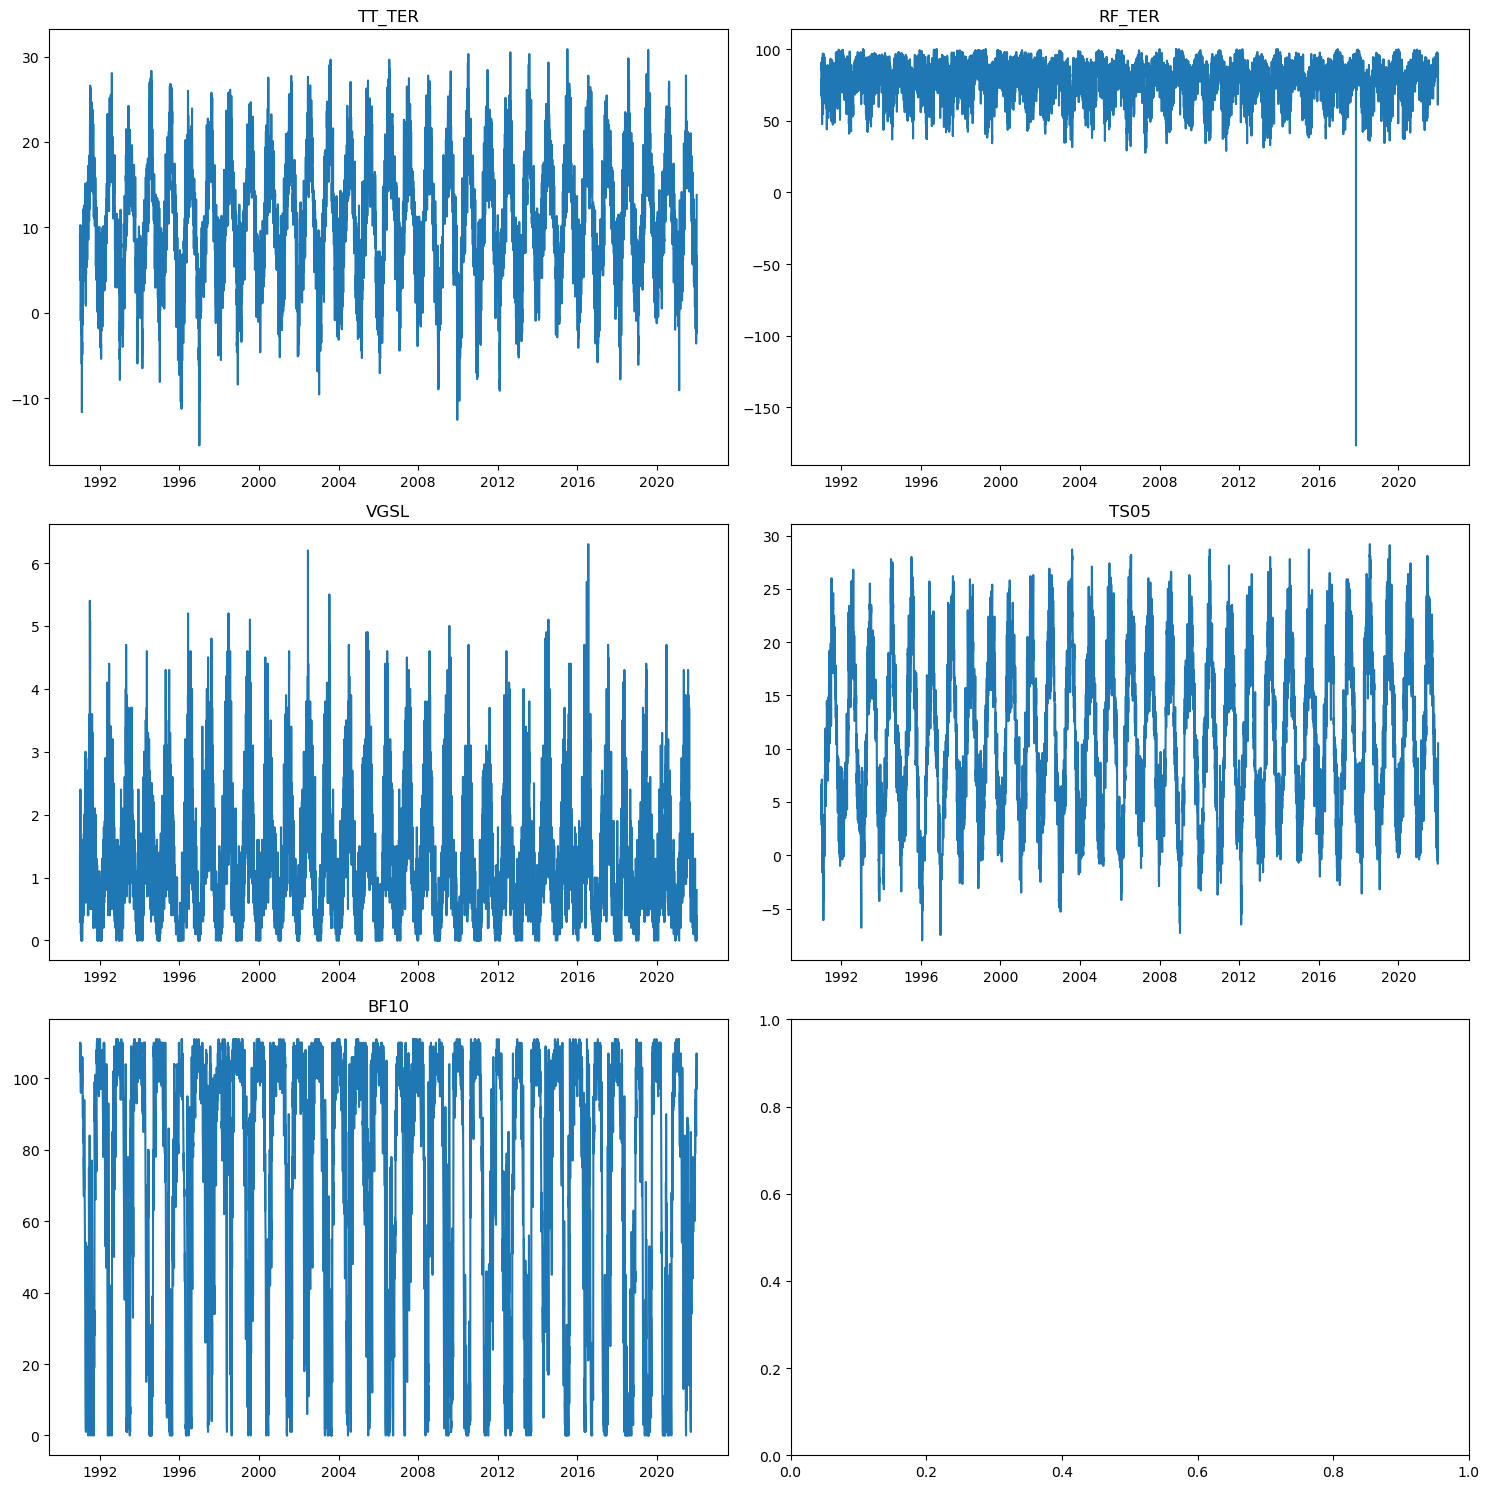

In [610]:
# plot all features, except for STATIONS_ID and QN_4

fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (15,15))

for i, feature in enumerate(to_explore_df.columns):
    row = i//2
    col = i%2
    ax[row, col].plot(to_explore_df[feature])
    ax[row, col].set_title(str(feature))

plt.tight_layout()
plt.show()

In [611]:
par_daily_df = to_explore_df.reset_index()

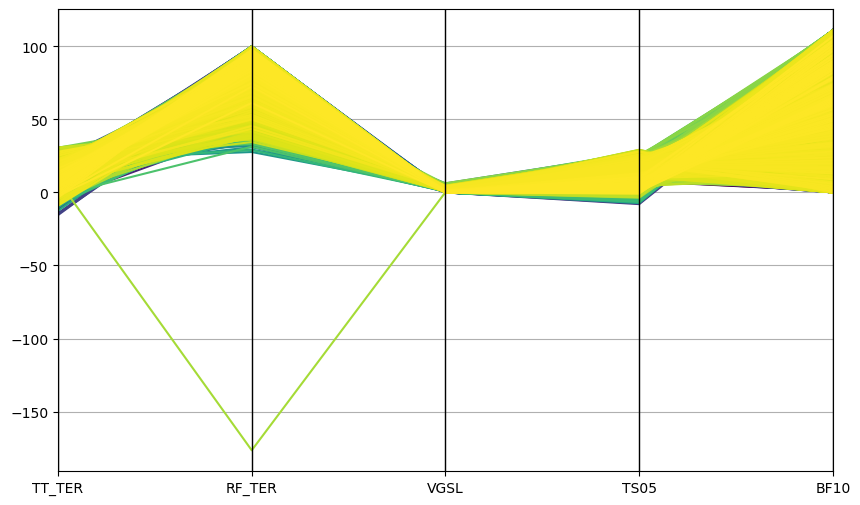

In [612]:
fig, ax = plt.subplots(figsize=(10, 6))

pd.plotting.parallel_coordinates(par_daily_df , 
                                 class_column= 'DATUM',
                                  colormap='viridis', ax = ax)
ax.legend().set_visible(False)

plt.show()

## 2-3- Temporal Analysis and Seasonal Patterns 

Utilizing the augmented Dickey-Fuller test, it is ascertained that both the target variable and accompanying features exhibit stationarity. Subsequent analysis involving the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots elucidates the time series characteristics inherent in the target variable, denoted as "BF10." The ACF plot manifests a pronounced temporal correlation extending up to approximately 90 lags, indicating a significant relationship with historical values. Conversely, the PACF plot underscores that the direct influence of lagged time steps on the current time step is not statistically significant.

In [613]:
#Checking for being stationary
for column in to_explore_df.columns:
    result = adfuller(to_explore_df[column])
    print(f'"{column}" is stationary') if result[1] < 0.05 else print(f'"{column}" is not stationary')

"TT_TER" is stationary
"RF_TER" is stationary
"VGSL" is stationary
"TS05" is stationary
"BF10" is stationary


In [614]:
# plot ACF and PACF 
def plot_ACF_PACF(df , feature, lag = 12):

    fig,axs = plt.subplots(1,2, figsize = (12,5))

    plot_acf(df[feature], lags= lag,zero=False, ax=axs[0])
    axs[0].set_title(f'ACF for {feature}')
    plot_pacf(df[feature], lags= lag,zero=False, method='ywm', ax=axs[1])
    axs[1].set_title(f'PACF for {feature}')

    plt.show()

In [615]:
# Define different values for lags
lags = [30, 60, 80, 90, 120, 150, 180]

# Calculate ACF for different lags
for lag in lags:
    acf = to_explore_df['BF10'].autocorr(lag=lag)
    print(f'The ACF related to lag "{lag}" => {acf}')

The ACF related to lag "30" => 0.5817916218678088
The ACF related to lag "60" => 0.31242485742185117
The ACF related to lag "80" => 0.12249401769049899
The ACF related to lag "90" => 0.03296973654514826
The ACF related to lag "120" => -0.22547517642407403
The ACF related to lag "150" => -0.4195773832707432
The ACF related to lag "180" => -0.5068757728511329


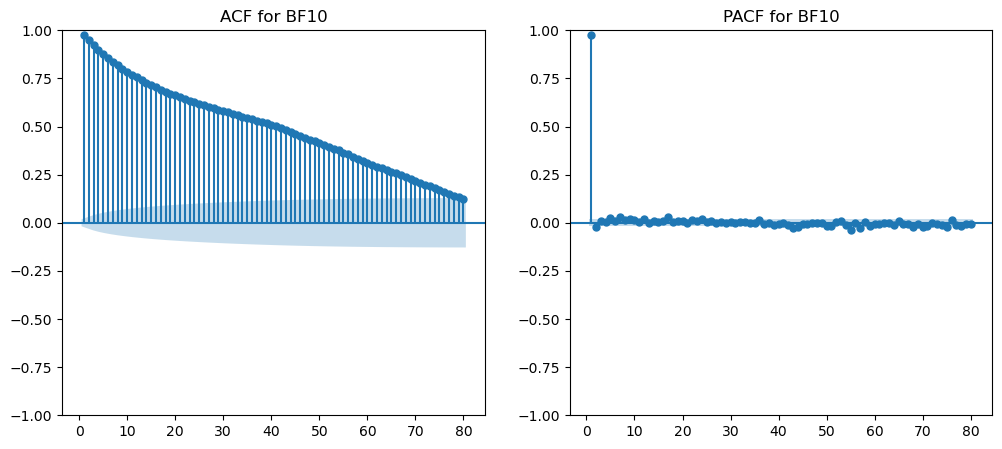

In [616]:
# Plot ACF and PACF of BF10
plot_ACF_PACF(to_explore_df, "BF10", 80)

A meticulous examination of the mean values of the target variable on an annual basis unveils a lack of discernible trend in soil moisture values over the period spanning 1991 to 2021. Contrarily, a more granular analysis of monthly variations exposes a distinct seasonal pattern in soil moisture levels. This cyclical trend initiates with elevated levels in January, progressively diminishes through May, June, and July, and subsequently ascends towards December.

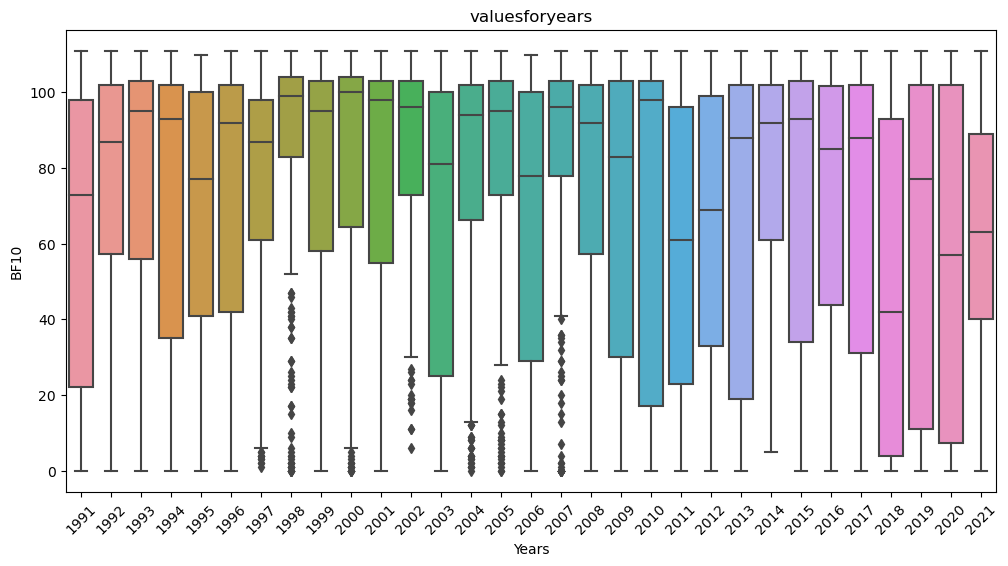

In [617]:
# Create a copy of to_explore_df DataFrame 
reindexed_df=to_explore_df.copy()

# Plot the boxplot for target variable on yearly basis 
fig,ax=plt.subplots(figsize=(12,6))
sns.boxplot(x=reindexed_df.index.year,y=reindexed_df["BF10"],ax=ax)
plt.title("valuesforyears")
plt.xlabel("Years")
plt.xticks(rotation=45)
plt.show()

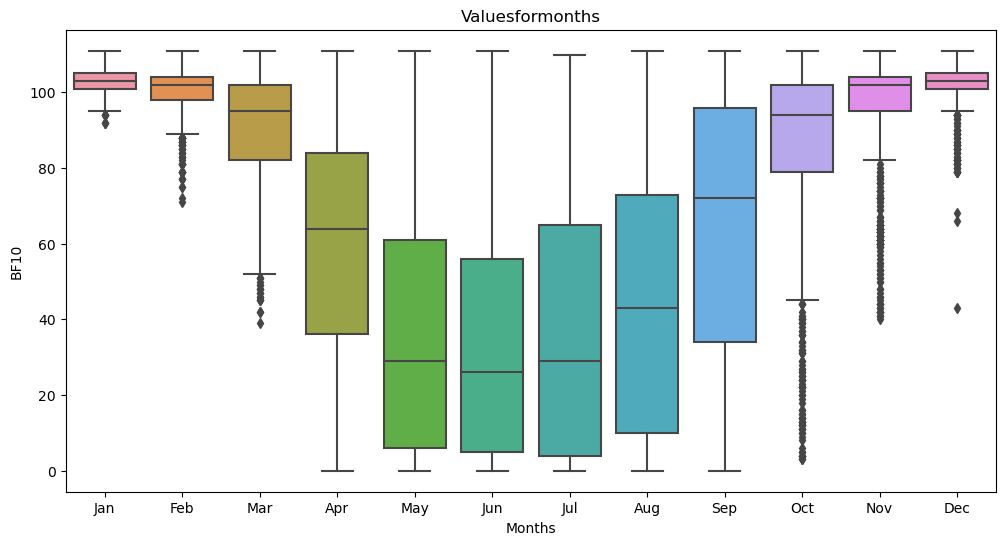

In [618]:
# Plot the boxplot for target variable on monthly basis 

fig,ax=plt.subplots(figsize=(12,6))
sns.boxplot(x=reindexed_df.index.strftime("%b"),y=reindexed_df["BF10"],ax=ax)
plt.title("Valuesformonths")
plt.xlabel("Months")
plt.show()

The application of the seasonal decomposition function further corroborates these observations. Post-decomposition, while no discernible trend is evident, a conspicuous seasonal pattern persists in the data. An examination of the residual plot substantiates the symmetric dispersion of residuals around zero. Collectively, these findings affirm the absence of a discernible trend in the mean values while substantiating the presence of a pronounced seasonal pattern in the target variable, "BF10."

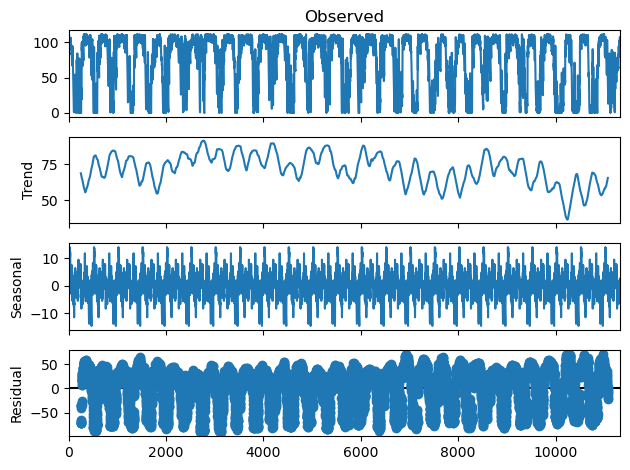

In [619]:
# Implement seasonal decomposition on BF10
analysis=seasonal_decompose(to_explore_df["BF10"].values,model="additive",period=500)
analysis.plot()
plt.show()

# 3- ***Data Preparation***

## 3-1- Removing Uninformative Feature:
In our analysis, we found that the "STATION_ID" feature contains only one value for all samples, making it unhelpful for our task. Consequently, we have decided to remove this feature from the dataset. This simplifies the data, making it more efficient for subsequent analysis and modeling.

In [620]:
daily_df['STATIONS_ID'].value_counts()

STATIONS_ID
1766.0    11323
Name: count, dtype: int64

In [621]:
daily_df.drop('STATIONS_ID', axis=1, inplace=True)

In [622]:
daily_df.head()

,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
DATUM,,,,,,
1991-01-01,10.0,3.900000,86.000000,0.3,2.9,102.0
1991-01-02,10.0,9.200000,90.666667,1.4,6.3,110.0
1991-01-03,10.0,7.733333,82.333333,1.0,6.6,110.0
1991-01-04,10.0,6.433333,76.666667,1.2,5.5,106.0
1991-01-05,10.0,5.466667,78.000000,1.0,3.7,109.0


## 3-2- Outlier Detection

In [623]:
def detect_anomalies_iqr(df):
    anomaly_df = pd.DataFrame(index=df.index)

    for feature in df.columns:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        anomaly_df[f'outlier_{feature}'] = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).astype(int)

    return anomaly_df

In [624]:
def plot_anomalies(df, anomaly_df, title):
    plt.figure(figsize=(12, 8))

    for i, feature in enumerate(df.columns):
        plt.subplot(2, 2, i + 1)
        plt.scatter(df.index, df[feature], c=np.where(anomaly_df[f'outlier_{feature}'] == 1, 'red', 'green'))
        plt.title(f'Anomalies - {feature}')

    plt.suptitle(title)
    plt.show()

In [625]:
input_df = daily_df.copy()

In [626]:
input_df.drop(['QN_4', 'BF10'],axis=1, inplace=True)

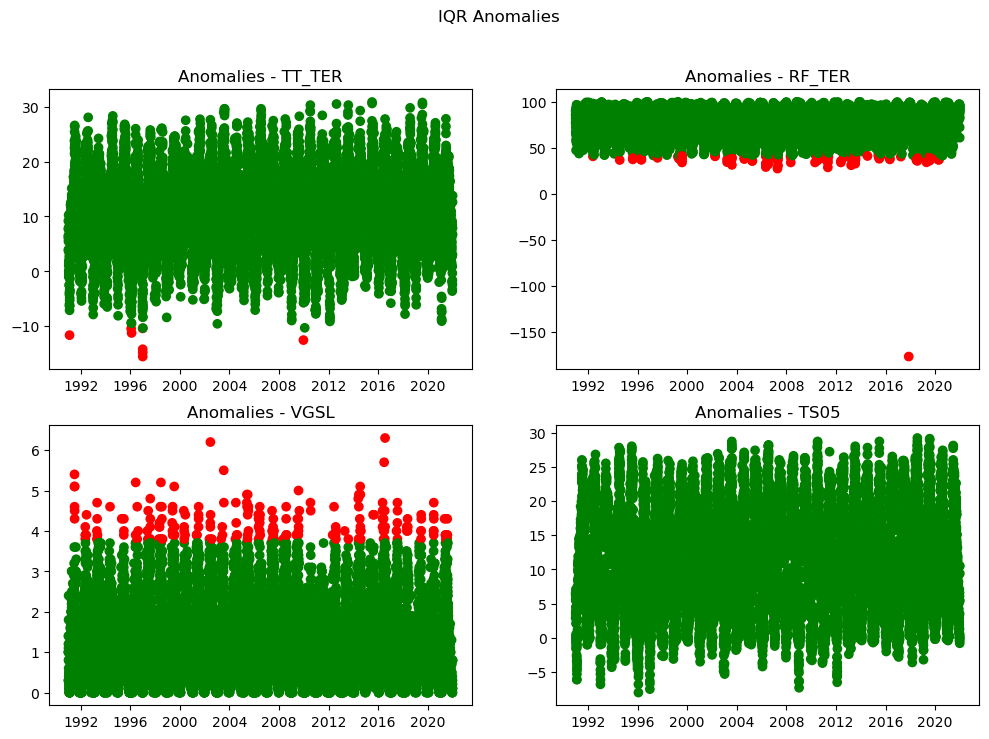

In [628]:
iqr_df = detect_anomalies_iqr(input_df)
plot_anomalies(input_df, iqr_df, title='IQR Anomalies')

# 4- ***Feature Selection and Engineering***

Feature Selection is the process of selecting a subset of relevant features for use in machine learning model building.

It is not always the truth that the more data, the better the result will be. Including irrelevant features (the ones that are just unhelpful to the prediction) and redundant features (irrelevant in the presence of others) will only make the learning process overwhelmed and easy to cause overfitting.
https://github.com/ashishpatel26/Amazing-Feature-Engineering/blob/master/A%20Short%20Guide%20for%20Feature%20Engineering%20and%20Feature%20Selection.md

By reducing the number of features, we can improve the performance of the machine learning models, while reducing training time and creating more interpretable machine learning models.
Feature selection methods have been traditionally grouped into filter methods, wrapper methods, and embedded methods.https://www.blog.trainindata.com/feature-selection-machine-learning-with-python/

In the course of this research, a comprehensive feature selection strategy has been employed, encompassing both filter and embedded methods. Specifically, two representative techniques from each category have been leveraged. Within the filter methods, correlation and mutual information have been applied, while within the embedded methods, Lasso regression and Random Forest feature importance have been employed.

To enhance the temporal dimension of the analysis, an additional layer of exploration has been introduced. Three new features—namely, year, month, and day—have been derived from the temporal data recording information. This augmentation aims to scrutinize the potential correlation between temporal factors and both the features and the target variable.

The utilization of filter methods, such as correlation and mutual information, facilitates the identification of features with direct relationships to the target variable, while embedded methods like Lasso and Random Forest are adept at capturing complex relationships and feature importance within a predictive modeling framework.

In [40]:
# Set date as a column
daily_df = daily_df.reset_index()

# Make a new feature for year
daily_df['year'] = daily_df['DATUM'].dt.year

# Make a new feature for month
daily_df['month'] = daily_df['DATUM'].dt.month

# Make a new feature for day
daily_df['day'] = daily_df['DATUM'].dt.day

# Set date as index
daily_df.set_index('DATUM', inplace=True)

# Extract features
featuers = daily_df.drop('BF10', axis='columns')

# Features name
featuers_name = featuers.columns

#Extract target variable
target = daily_df['BF10']

In [41]:
daily_df.head()

,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10,year,month,day
DATUM,,,,,,,,,
1991-01-01,10.0,3.900000,86.000000,0.3,2.9,102.0,1991,1,1
1991-01-02,10.0,9.200000,90.666667,1.4,6.3,110.0,1991,1,2
1991-01-03,10.0,7.733333,82.333333,1.0,6.6,110.0,1991,1,3
1991-01-04,10.0,6.433333,76.666667,1.2,5.5,106.0,1991,1,4
1991-01-05,10.0,5.466667,78.000000,1.0,3.7,109.0,1991,1,5


## 4-1- Correlation Matrix

The analysis of feature correlations with the target variable, BF10 (soil moisture), reveals discernible linear associations indicative of their respective impacts. Among the eight features under consideration, it is clear that four features TS05(mean daily soil temperature in 5 cm depth for uncovered typical soil), TT_TER(air temperature), RF_TER(relative humidty), and VGSL(real evapotranspiration over gras and sandy loam) have the highest linear relationship to BF10(soil moisture).

This observation underscores the significance of these particular features in influencing soil moisture levels. The inclusion of time-related features, such as TS05, alongside meteorological parameters like air temperature (TT_TER) and relative humidity (RF_TER), emphasizes the complex interplay between environmental factors and soil moisture dynamics. Additionally, VGSL, representing real evapotranspiration over grass and sandy loam, emerges as a key contributor to the linear relationship with soil moisture, highlighting the intricate ecohydrological processes at play.

In [42]:
# Calculate the correlation of features to target variable
corr_to_target = daily_df.corr(numeric_only=True)['BF10']

# Show results in Descending order
cor_matrix_df = pd.DataFrame(corr_to_target.abs()).sort_values( 'BF10', ascending=False)
cor_matrix_df.drop('BF10', axis=0, inplace=True)
cor_matrix_df.rename(columns={'BF10':'Corr'}, inplace=True)
cor_matrix_df

,Corr
TS05,0.718124
TT_TER,0.655598
RF_TER,0.599611
VGSL,0.357922
QN_4,0.159342
year,0.115049
day,0.011208
month,0.003767


Upon meticulous examination of feature correlations, it becomes evident that the most substantial correlation pertains to TS05 (mean daily soil temperature) and TT_TER (air temperature), a phenomenon that aligns logically with their inherent connection in environmental dynamics. Further analysis reveals that air temperature (TT_TER) exhibits a notable positive linear relationship with VGSL (real evapotranspiration over grass and sandy loam) and a discernible negative relationship with RF_TER (relative humidity). These findings underscore the intricate interdependencies among meteorological parameters.

This scrutiny into correlations unveils a broader network of significant linear relationships among features. Specifically, the aforementioned four features—TS05, TT_TER, RF_TER, and VGSL—display not only noteworthy linear associations with the target variable but also exhibit pronounced linear relationships amongst themselves. This intricate interplay reinforces the notion that the environmental variables under consideration are not only influential in predicting soil moisture but are also interconnected, reflecting the intricate dynamics of soil-weather interactions.

,QN_4,TT_TER,RF_TER,VGSL,TS05,year,month,day
QN_4,1.000000,-0.040668,0.019330,0.039248,-0.059562,-6.234127e-01,-3.018496e-02,-1.281884e-03
TT_TER,-0.040668,1.000000,-0.502770,0.646747,0.968921,5.744581e-02,1.775435e-01,3.740320e-03
RF_TER,0.019330,-0.502770,1.000000,-0.538707,-0.522614,-6.782455e-02,1.649817e-01,3.676479e-03
VGSL,0.039248,0.646747,-0.538707,1.000000,0.664640,-2.890511e-02,-1.205998e-01,3.194797e-03
TS05,-0.059562,0.968921,-0.522614,0.664640,1.000000,4.874558e-02,1.544643e-01,5.903271e-03
year,-0.623413,0.057446,-0.067825,-0.028905,0.048746,1.000000e+00,-9.242554e-15,2.358393e-15
month,-0.030185,0.177544,0.164982,-0.120600,0.154464,-9.242554e-15,1.000000e+00,1.047819e-02
day,-0.001282,0.003740,0.003676,0.003195,0.005903,2.358393e-15,1.047819e-02,1.000000e+00


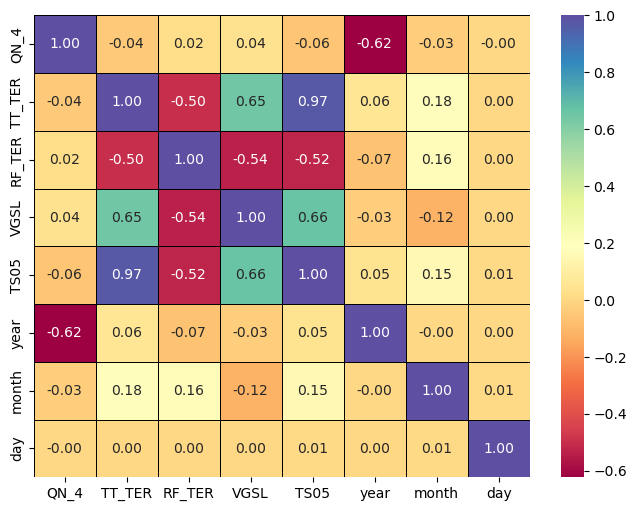

In [43]:
# Create correlation matrix for features
feature_corr = featuers.corr(numeric_only=True)

# Display correlation matrix
display(feature_corr)

# Plot correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(feature_corr, annot=True, fmt='0.2f', linewidths=0.5, linecolor='Black', cmap='Spectral')
plt.show()

## 4-2- Mutual information
The Mutual Information between two random variables measures non-linear relations between them. Besides, it indicates how much information can be obtained from a random variable by observing another random variable.

It is closely linked to the concept of entropy. This is because it can also be known as the reduction of uncertainty of a random variable if another is known. Therefore, a high mutual information value indicates a large reduction of uncertainty whereas a low value indicates a small reduction. If the mutual information is zero, that means that the two random variables are independent. https://quantdare.com/what-is-mutual-information/

Two benefits to using Mutual Information as feature selector:
- The MI is model neutral, which means the solution can be applied to various kinds of ML models.
- MI solution is fast. 
https://towardsdatascience.com/select-features-for-machine-learning-model-with-mutual-information-534fe387d5c8

The outcomes derived from mutual information analysis unveil a noteworthy pattern, as TS05 (mean daily soil temperature), TT_TER (air temperature), RF_TER (relative humidity), and VGSL (real evapotranspiration over grass and sandy loam) emerge prominently among the top five features demonstrating the highest mutual information content with the target variable, BF10 (soil moisture). This observation reaffirms the significance of these meteorological and environmental parameters in influencing soil moisture dynamics.

Remarkably, another feature that attains a position of prominence in this analysis is the newly introduced temporal feature, "month." The inclusion of this temporal dimension further underscores the multifaceted nature of the dataset, where not only meteorological variables but also temporal factors play a pivotal role in elucidating the soil moisture patterns.

In [44]:
# Calculate mutual information score
mutual_score = mutual_info_regression(featuers,target)

# Display results in a dataframe in descending order
mutual_df = pd.DataFrame(mutual_score, columns=['Mutual score'], index=featuers_name).sort_values('Mutual score', ascending= False)
mutual_df

,Mutual score
month,0.425104
TS05,0.419249
TT_TER,0.329830
VGSL,0.285602
RF_TER,0.268765
year,0.074343
QN_4,0.011007
day,0.007591


## 4-3-Lasso

Conducting a Lasso regression analysis on the dataset and subsequently extracting the coefficients associated with each feature unveils noteworthy insights into their predictive contributions to the target variable, BF10 (soil moisture). Once again, TS05 (mean daily soil temperature), TT_TER (air temperature), RF_TER (relative humidity), and VGSL (real evapotranspiration over grass and sandy loam) emerge as primary contributors, securing positions among the top five features with the highest coefficients.

However, in this instance, the novel inclusion of the temporal feature "month" assumes a distinct position, ranking sixth in terms of its coefficient magnitude.

In [45]:
# Build a Lasso Model to fit on Data and extract the coefficients
lasso_model = Lasso()
lasso_model.fit(featuers, target)
coefficients = lasso_model.coef_

# Display the coefficients of features for Lasso model from the most important one to the least important
coef = pd.DataFrame(coefficients, columns=['Lasso_Coef'], index=featuers_name)
coef = coef.reindex(coef['Lasso_Coef'].abs().sort_values(ascending=False).index)
coef

,Lasso_Coef
VGSL,11.257585
TS05,-5.621560
TT_TER,2.359560
QN_4,1.186161
RF_TER,1.017502
month,0.717898
day,-0.024565
year,-0.000000


## 4-4- Random Forest

Applying the Random Forest algorithm to the dataset and extracting feature importance reveals compelling insights into the variables that exert the most influence on predicting soil moisture levels. Evidently, the top three impactful features identified by this method are TS05 (mean daily soil temperature), RF_TER (relative humidity), and VGSL (real evapotranspiration over grass and sandy loam). Intriguingly, the temporal feature "year" makes its debut among the first five important features in this analysis. Conversely, the feature TT_TER (air temperature) secures a position as the sixth most important.

It is imperative to contextualize these findings in light of the correlation matrix, where we observed a notable correlation between TT_TER and TS05, RF_TER, VGSL. When a feature exhibits high correlation with other variables, as in the case of TT_TER, it may influence its feature importance within the Random Forest model. This underscores the interconnected nature of meteorological variables and the importance of considering their collective influence on predictive modeling outcomes.

In [46]:
# Build a Random Forest Model to fit on Data and extract the feature importance
rf_model = RandomForestRegressor()
rf_model.fit(featuers, target)
feature_importance = rf_model.feature_importances_

# Display the importance of features for Random Forest model from the most important one to the least important
importance = pd.DataFrame(feature_importance, index=featuers_name, columns=['RF_Importance'])
importance.sort_values('RF_Importance', ascending=False, inplace=True)
importance

,RF_Importance
TS05,0.521504
RF_TER,0.151367
VGSL,0.110101
year,0.083700
month,0.066278
TT_TER,0.033020
day,0.031578
QN_4,0.002453


## 4-5- Results

In [47]:
# Display all results together 
all_importance = pd.concat([importance, coef, mutual_df, cor_matrix_df], axis=1)
all_importance.sort_values(['RF_Importance'], ascending=False)

,RF_Importance,Lasso_Coef,Mutual score,Corr
TS05,0.521504,-5.621560,0.419249,0.718124
RF_TER,0.151367,1.017502,0.268765,0.599611
VGSL,0.110101,11.257585,0.285602,0.357922
year,0.083700,-0.000000,0.074343,0.115049
month,0.066278,0.717898,0.425104,0.003767
TT_TER,0.033020,2.359560,0.329830,0.655598
day,0.031578,-0.024565,0.007591,0.011208
QN_4,0.002453,1.186161,0.011007,0.159342


In synthesizing the optimal features for model creation, a systematic approach is employed. The frequency of appearance of each feature within the top six features, as identified by the various selection methods, is tabulated. Subsequently, the two numbers with the highest occurrences are singled out, and the corresponding features are selected for inclusion in the final model

Upon examination of the dedicated dataframe constructed for this purpose, it is observed that TS05, RF_TER, VGSL, and TT_TER feature prominently, each appearing four times. Furthermore, the temporal features, namely "year" and "month," exhibit three occurrences in the aggregated top six features lists across the four feature selection methods applied.

As a result, the definitive set of features earmarked for the final model comprises TS05, RF_TER, VGSL, TT_TER, "year," and "month".

In [48]:
# Create list of six important features of each method
rf_first6 = importance.iloc[0:6].index.to_list()
lasso_first6 = coef.iloc[0:6].index.to_list()
mi_first6 = mutual_df.iloc[0:6].index.to_list()
corr_first6 = cor_matrix_df.iloc[0:6].index.to_list()

first6_list = [rf_first6, lasso_first6, mi_first6, corr_first6]

In [49]:
# Select features with the 2 highest occurrence
feature_score = dict()

for first6 in first6_list:
    for featuer in first6:
        feature_score[featuer] = feature_score.get(featuer,0)+1

pd.DataFrame(feature_score.values(), index=feature_score.keys(), columns=['Score'])\
    .sort_values('Score', ascending=False)    

,Score
TS05,4
RF_TER,4
VGSL,4
TT_TER,4
year,3
month,3
QN_4,2


In [70]:
# Create the Final Data Frame to work with
selected_feature = ['TS05','RF_TER','VGSL','TT_TER','year','month', 'BF10']
final_df = daily_df[selected_feature]
final_df.shape

(11323, 7)

## 4-6- Scaling

n preparation for the implementation of diverse models, it is noteworthy that certain models, such as the Huber Regressor and Random Forest, exhibit insensitivity to data scaling. Nevertheless, a standardized scaling approach will be applied uniformly across all models, including those sensitive to data scale, in the subsequent sections—most notably, Support Vector Machines (SVM) and Long Short-Term Memory (LSTM) models.

The selected scaling method for this study is the Robust Scaler, chosen for its robustness to outliers. The presence of outliers in the dataset, as revealed during Exploratory Data Analysis (EDA), necessitates a meticulous approach to outlier management. Given the intricacies associated with handling and imputing outliers, this study opts for the robust scaling method in tandem with suitable models, ensuring a judicious treatment of outlier influences.

The application of the robust scaler will be confined to the features exclusively, encompassing both datasets earmarked for conventional machine learning algorithms and those tailored for LSTM. Notably, this scaling procedure excludes the target variable. The rationale behind this choice lies in the recognition that scaling the target variable does not impact the training process. Consequently, in subsequent analyses and metric computations, the omission of target variable scaling simplifies the process of inverse scaling, enhancing interpretability and analysis efficiency.

In [91]:
# Create a function to implement scaling
def scaling(scaler, x_df):
    scale = scaler
    scale.set_output(transform = 'pandas')
    scaled_data  = scale.fit_transform(x_df)
    return scaled_data

# 5- ***Machine learning Models Implementation***

## 5-1 Model Training and Evaluation Strategy 

In this section, three distinct models will be employed and trained for predictive purposes. Commencing with the Huber Regressor as the initial model, it serves as a baseline for comparative evaluation. The Huber Regressor employs the Huber loss function, known for its robustness in handling outliers. This choice aligns with the intention of establishing a resilient baseline model.

The second model in consideration is the Random Forest Regressor, an ensemble-based approach renowned for its robustness. Leveraging the ensemble nature of the Random Forest Regressor enables more dependable predictions, particularly in the presence of outliers. Furthermore, given the established stationarity of the time series, as identified during the Exploratory Data Analysis (EDA), implementing this algorithm becomes particularly beneficial.

The third and final model introduced is the Support Vector Regressor (SVR). Capable of handling multivariate time series predictions without necessitating stationary transformations, SVR is deemed suitable for our dataset, which is fortuitously already stationary. Additionally, SVR is aptly suited for scenarios where robustness to outliers is a paramount consideration.

The procedural approach entails scaling the feature dataset using the chosen scaler after creating both features and target datasets. Subsequently, the data is partitioned into training and test datasets. For each model, hyperparameter tuning is performed, followed by training the model on the training dataset. The trained model is then applied to the test dataset for subsequent analysis. The Mean Absolute Error (MAE) serves as the primary metric for both tuning and evaluation. Additionally, alongside MAE, two supplementary metrics, Mean Squared Error (MSE) and R-squared (coefficient of determination), are monitored for a comprehensive assessment of model performance.

## 5-2 Data Scaling and Train, Test Split

As it was mentioned in section 4, the scaling method used to scale data is Robust Scaler. 

This Scaler removes the median and scales the data according to the quantile range. The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data.

Standardization of a dataset is a common preprocessing for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean/ variance in a negative way. In such cases, using the median and the interquartile range often give better results

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

In [71]:
# Create data set for ml-models implementation
ml_df = final_df.copy()
print(ml_df.shape)
ml_df.head()

(11323, 7)


,TS05,RF_TER,VGSL,TT_TER,year,month,BF10
DATUM,,,,,,,
1991-01-01,2.9,86.000000,0.3,3.900000,1991,1,102.0
1991-01-02,6.3,90.666667,1.4,9.200000,1991,1,110.0
1991-01-03,6.6,82.333333,1.0,7.733333,1991,1,110.0
1991-01-04,5.5,76.666667,1.2,6.433333,1991,1,106.0
1991-01-05,3.7,78.000000,1.0,5.466667,1991,1,109.0


In [97]:
# Create the features and the targe data set
ml_features = ml_df.drop('BF10', axis=1)
ml_y = ml_df['BF10']

print(f'Shape of features data set for ML models => {ml_features.shape}')
print(f'Shape of target for ML models => {ml_y.shape}')

Shape of features data set for ML models => (11323, 6)
Shape of target for ML models => (11323,)


In [98]:
# Execute Robust scaling on features data set
ml_X = scaling(RobustScaler(), ml_features)
ml_X.shape

(11323, 6)

In [101]:
ml_X.shape, ml_y.shape

((11323, 6), (11323,))

In [259]:
# Split data to train and test data sets with test data set of 15%
test_size = 0.15
ml_X_train, ml_X_test, ml_y_train, ml_y_test = train_test_split(ml_X, ml_y,
                                                        test_size= test_size,
                                                            shuffle=False,
                                                            random_state= 42 )

shapes = [[ml_X_train.shape,ml_y_train.shape],[ml_X_test.shape,ml_y_test.shape]]
shape =pd.DataFrame(shapes, columns=['X', 'y'], index=['Train', 'Test'])
display(shape)

,X,y
Train,"(9624, 6)","(9624,)"
Test,"(1699, 6)","(1699,)"


## 5-3 Requiered Functions To Tune, Implement, and evaluate ML Models

In this segment, four pivotal functions have been meticulously crafted to facilitate the tuning, execution, and visualization of predictive models.

The first function, 'tuner,' is designed to optimize model performance by leveraging the RandomizedSearchCV technique. It takes as input a model and a dictionary encapsulating the hyperparameters for tuning. Through a defined number of iterations, the function systematically explores and evaluates various hyperparameter combinations to identify the configuration that minimizes the Mean Absolute Error (MAE).

The 'run_model' function plays a central role in training the model and evaluating its performance. Given the model and the optimal hyperparameter configuration, it conducts training on the designated training dataset. Additionally, the function computes essential metrics—MAE, Mean Squared Error (MSE), and R-squared (R_2)—for both the test and training datasets. This dual evaluation enables a comprehensive analysis of bias and variance in the model. The function further contributes to this analysis by generating a learning curve, visually illustrating the behavior of bias and variance.

The last two functions, 'plot_predictions' and 'plot_residuals,' are dedicated to visualizing the model's performance. 'plot_predictions' presents a graphical representation of the model's predictions on both the training and test datasets. Meanwhile, 'plot_residuals' provides insightful visualizations of the residuals, offering a nuanced understanding of the model's predictive errors.

In [260]:
def tunner(model, params,cv=5, iteration = 4):
    tscv = TimeSeriesSplit(n_splits=cv)

    tunner = RandomizedSearchCV(estimator=model, param_distributions=params, cv=tscv, n_iter=iteration,
                                scoring= "neg_mean_absolute_error", random_state=42)
    
    tunner.fit(ml_X_train, ml_y_train)

    best_parameters = tunner.best_params_
    best_score = tunner.best_score_

    result = pd.DataFrame( index=best_parameters.keys(), columns=['value'], data = best_parameters.values())

    print(f'Best mean absolute error during tunning is => {best_score}')
    display(result)
    return best_parameters
    

In [271]:
def run_model(model, best_parameters):

    ########## Create the best model and fit to training data set ######### 
    model = model(**best_parameters)

    model.fit(ml_X_train, ml_y_train)

    ########## Do predictions on Training and Test Data sets and calculate metrics #########
    pred_xtrain = model.predict(ml_X_train)
    pred_xtest = model.predict(ml_X_test)

    # Calculate metrics 
    MAE = mean_absolute_error(ml_y_test,pred_xtest)
    MSE = mean_squared_error(ml_y_test,pred_xtest)
    R_2 = r2_score(ml_y_test,pred_xtest)

    # Calculate metrics of Training data set
    train_MAE = mean_absolute_error(ml_y_train,pred_xtrain)
    train_MSE = mean_squared_error(ml_y_train,pred_xtrain)
    train_R_2 = r2_score(ml_y_train,pred_xtrain)



    # provide metrics in the format of dataframe
    evaluation = {'MAE':[MAE, train_MAE],'MSE':[MSE, train_MSE], 'R_2': [R_2, train_R_2]}
    eval_df = pd.DataFrame(evaluation, index=[f'{model} Test set metrics', 'Train set metrics'])
    display(eval_df)


    # Plot learning curves to visualize bias and variance
    train_sizes, train_scores, test_scores = learning_curve(model, ml_X_train, ml_y_train, 
                                                            cv=5, scoring='neg_mean_absolute_error',
                                                            )

    train_mse_mean = -np.mean(train_scores, axis=1)
    test_mse_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mse_mean, label='Training error')
    plt.plot(train_sizes, test_mse_mean, label='Testing error')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Absolute Error')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

    return eval_df, pred_xtrain, pred_xtest

In [272]:
# Function for plotting predicted values for train and test data sets 
def plot_predictions(train_predict, test_predict):
    plt.figure(figsize=(8,4))

    # plot Actual anomaly value
    plt.plot(ml_y, label = 'BF10 value') 

    # plot predicted values for train, and test data sets 
    plt.plot(ml_y_train.index, train_predict, label = 'prediction on train set')
    plt.plot(ml_y_test.index,test_predict, label = 'prediction on test set')
    
    plt.xlabel('Time')
    plt.ylabel('BF10')
    plt.legend()
    
    plt.show()

In [273]:
# Function to Plot residuals for train, and test data sets
def plot_residuals(train_predict, test_predict):
    

    # Calculate residuals for train, and test sets
    train_residuals = (ml_y_train - train_predict)
    test_residuals = (ml_y_test - test_predict)

    fig, axs = plt.subplots(figsize = (8,4))

    # plot residuals over time
    axs.scatter(ml_y_train.index, train_residuals)
    axs.scatter(ml_y_test.index, test_residuals)
    axs.axhline(0, color = 'red')
    axs.set_xlabel('Time')
    axs.set_ylabel('Residuals')
    axs.set_title('Residuals over time')

    plt.show()

## 5-4 Huber Regressor

The Huber Regressor optimizes the squared loss for the samples where |(y - Xw - c) / sigma| < epsilon and the absolute loss for the samples where |(y - Xw - c) / sigma| > epsilon, where the model coefficients w, the intercept c and the scale sigma are parameters to be optimized. The parameter sigma makes sure that if y is scaled up or down by a certain factor, one does not need to rescale epsilon to achieve the same robustness. Note that this does not take into account the fact that the different features of X may be of different scales.
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html

there are two important parameters to tune in huber regressor:
- epsilon: The parameter epsilon controls the number of samples that should be classified as outliers. The smaller the epsilon, the more robust it is to outliers
- alpha: Strength of the squared L2 regularization. Note that the penalty is equal to alpha * ||w||^2. 

In [274]:
# Create a dictionary of hyper parameters for huber regressor
huber_params = {'alpha': [0.01, 0.1, 1, 10, 100], 'epsilon': [1, 1.2,1.5,2, 2.5]}

In [275]:
# Create huber regressor instance
huber_model = HuberRegressor()

# Tune the huber regressor
huber_best_params = tunner(huber_model, huber_params, iteration=20)

Best mean absolute error during tunning is => -17.013280677109055


,value
epsilon,2
alpha,1


Upon training the tuned model and conducting a comprehensive evaluation of metrics, it becomes evident that the Huber Regressor demonstrates a commendable level of performance. The Mean Absolute Error (MAE) for the test dataset stands at 18.78, accompanied by a coefficient of determination (R-squared) of 61.5%. However, a closer examination of these metrics for the training dataset reveals an MAE of 16.27 and a higher R-squared value of 67.2%. This discrepancy suggests a potential instance of relative overfitting during the training process, indicative of a model with lower bias and higher variance.

This inclination towards overfitting is further illuminated by the learning curve, where the test error consistently surpasses the train error across varying training set sizes. The discernible gap between the two curves reinforces the presence of higher variance, contributing to the observed overfitting phenomenon. Intriguingly, the learning curve also intimates that increasing the training set size may serve as a potential mitigation strategy for addressing the issue of high bias, thereby fostering a more balanced model performance.

,MAE,MSE,R_2
"HuberRegressor(alpha=1, epsilon=2) Test set metrics",18.779461,625.406031,0.614982
Train set metrics,16.267232,424.349636,0.671859


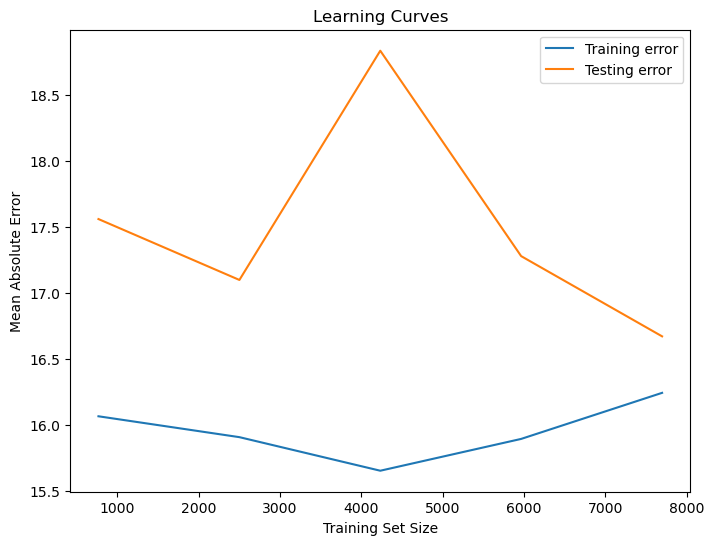

In [276]:
# train the tuned huber regressor
hu_eval_df, hu_pred_xtrain, hu_pred_xtest = run_model(HuberRegressor, huber_best_params)

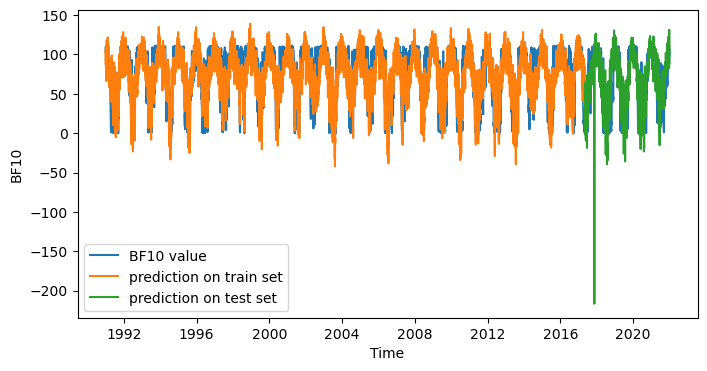

In [277]:
plot_predictions(hu_pred_xtrain, hu_pred_xtest)

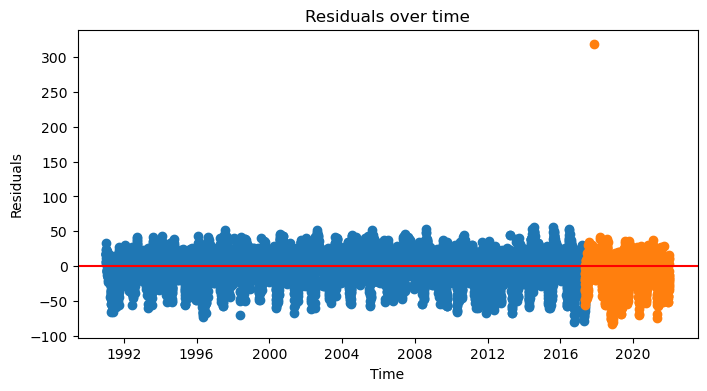

In [278]:
plot_residuals(hu_pred_xtrain, hu_pred_xtest)

## 5-5 Random Forest Regressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

The hyperparameter tuning process for the Random Forest Regressor unfolds in two distinct stages. Initially, a set of hyperparameters is chosen, each with its specified range. Following the observation of outcomes from the first stage, the second tuning phase is initiated specifically for hyperparameters that exhibited results at the boundary or threshold of the first stage. This iterative approach refines the tuning process, allowing for a more nuanced adjustment of hyperparameter values.

In [279]:
# Define hyper-parameters
n_estimators = [int(x) for x in np.linspace(start = 50,stop = 300, num = 6)] # define 5 values for n_stimator
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 10, stop = 50, num = 4)] # define 4 values for max_depth
max_depth.append(None) # to include the default value of sklearn for this hyperprameter. So max_depth have 5 values
min_samples_split = [5,10, 15]
min_samples_leaf = [4, 6, 8]

# Set hyper-parameters
rf_params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf  
}

In [280]:
# Instantiate Random Forest Regressor
rf_model = RandomForestRegressor()

# Tune the model phase 1
rf_best_params = tunner(rf_model, rf_params, iteration= 30)

Best mean absolute error during tunning is => -13.785697696552138


,value
n_estimators,300
min_samples_split,5
min_samples_leaf,4
max_features,sqrt
max_depth,50


In [283]:
# Define hyper-parameters Phase 2
n_estimators = [int(x) for x in np.linspace(start = 300,stop = 500, num = 3)] 
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(start = 40, stop = 60, num = 3)]
min_samples_split = [3, 5]
min_samples_leaf = [2,4]

# Set hyper-parameters phase 2
rf_params1 = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf  
}

In [285]:
# Tune the model Phase 2
rf_best_params1 = tunner(rf_model, rf_params1, iteration= 20)

Best mean absolute error during tunning is => -13.717763617377177


,value
n_estimators,300
min_samples_split,3
min_samples_leaf,2
max_features,sqrt
max_depth,50


The analysis reveals that, following the training of the tuned models and a thorough evaluation of metrics, the Random Forest Regressor exhibits a superior level of performance in comparison to the Huber Regressor. The Mean Absolute Error (MAE) for the test dataset is recorded at 15.47, coupled with a coefficient of determination (R-squared) of 73%. However, upon scrutinizing these metrics for the training dataset, a notable discrepancy emerges, with an MAE of 5.7 and a higher R-squared value of 94.5%. This discrepancy points toward a pronounced instance of overfitting during the training process, indicative of a model characterized by low bias and exceedingly high variance.

The overfitting tendency is further elucidated by the learning curve, wherein the test error consistently exceeds the train error with a substantial margin across varying training set sizes. This widening gap accentuates the presence of a high overfitting phenomenon. Notably, the learning curve suggests that increasing the training set size may not serve as an effective strategy for mitigating the issue of high bias, presenting a challenge in achieving a more balanced model performance.

,MAE,MSE,R_2
"RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=2,\n min_samples_split=3, n_estimators=300) Test set metrics",15.469408,437.146294,0.730880
Train set metrics,5.704183,71.558636,0.944665


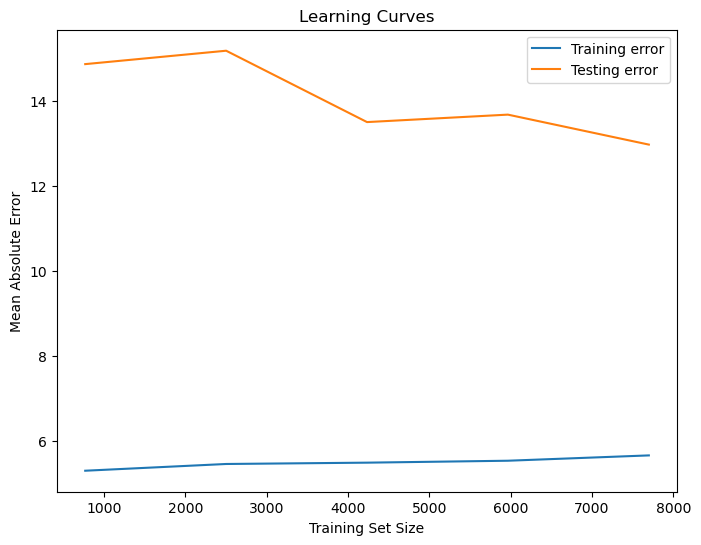

In [286]:
# Run tuned Random Forest Regressor
rf_eval_df, rf_pred_xtrain, rf_pred_xtest = run_model(RandomForestRegressor, rf_best_params1)

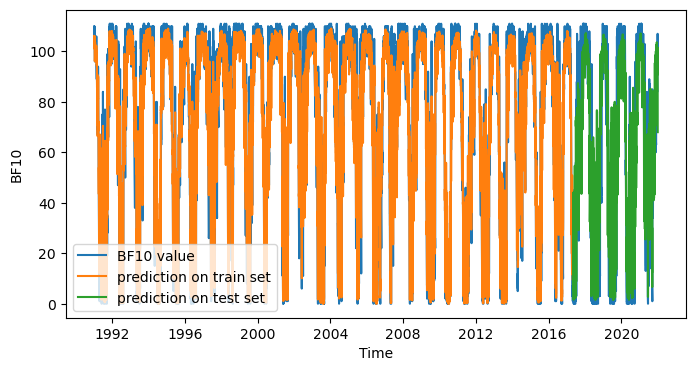

In [287]:
plot_predictions(rf_pred_xtrain, rf_pred_xtest)

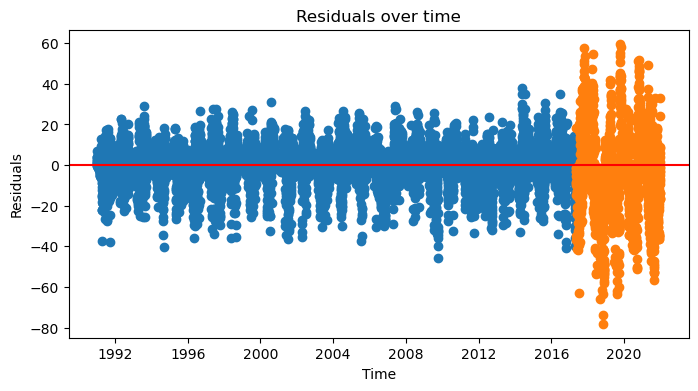

In [288]:
plot_residuals(rf_pred_xtrain, rf_pred_xtest)

## 5-5 SVR

SVR (Support Vector Regression) has several important parameters that influence its performance:

Epsilon: It determines the margin of error allowed in SVR predictions. Larger values provide more tolerance for errors, while smaller values make the model stricter.

Kernel: It defines the similarity measure between data points. Different kernels capture different patterns in the data.

C: It balances the trade-off between training error and model complexity. Smaller values result in simpler models with potentially higher bias, while larger values lead to more complex models with potentially higher variance.

The SVR undergoes a hyperparameter tuning process employing a strategy analogous to that of the Random Forest Regressor. Initially, a set of hyperparameters is selected, each assigned a specified range. Subsequently, upon assessing outcomes from the first stage, the second tuning phase is launched specifically for hyperparameters that demonstrated results at the boundary or threshold during the initial phase.

In [289]:
# Set Hyper parameters, phase 1
svr_params = {
            'kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
            'C' : [1, 5, 10, 20],
            'epsilon' : [0.01, 0.1, 10, 20],           
            }

In [290]:
# Instanciate the model
svr_model = SVR()

# Tune SVR phase 1
svr_best_params = tunner(svr_model, svr_params, iteration= 30)

Best mean absolute error during tunning is => -13.120236502373379


,value
kernel,rbf
epsilon,0.01
C,20


In [291]:
# Set hyper parameters phase 2
svr_params1 = {
            'kernel' : ['rbf'],
            'C' : [20, 50, 100],
            'epsilon' : [0.001 ,0.01, 0.1],           
            }

In [292]:
# Tune SVR phase 2
svr_best_params = tunner(svr_model, svr_params1, iteration= 9)

Best mean absolute error during tunning is => -13.076262707649406


,value
kernel,rbf
epsilon,0.001
C,50


The evaluation of the Support Vector Regressor (SVR) reveals notable performance metrics. The Mean Absolute Error (MAE) for the test dataset is measured at 15.61, with a corresponding coefficient of determination (R-squared) of 69%. This signifies an improved performance compared to the Huber Regressor and marginally lags behind the Random Forest Regressor. However, a closer examination of these metrics for the training dataset reveals an MAE of 10.59 and an R-squared value of 79.4%. This discrepancy indicates overfitting during the training process for SVR. Notably, the observed differences in bias/variance are more favorable compared to the Random Forest Regressor.

The manifestation of overfitting is also evident in the learning curve, where the test error consistently surpasses the train error. Yet, with an increase in the training set size, these differences steadily diminish, signifying a continuous reduction in variance. This characteristic demonstrates the superior performance of SVR compared to the Random Forest Regressor. Moreover, the learning curve's shape surpasses that of the Huber Regressor, underscoring the efficacy of SVR in achieving a favorable balance between bias and variance. 

,MAE,MSE,R_2
"SVR(C=50, epsilon=0.001) Test set metrics",15.615237,500.642799,0.691790
Train set metrics,10.591206,266.574554,0.793863


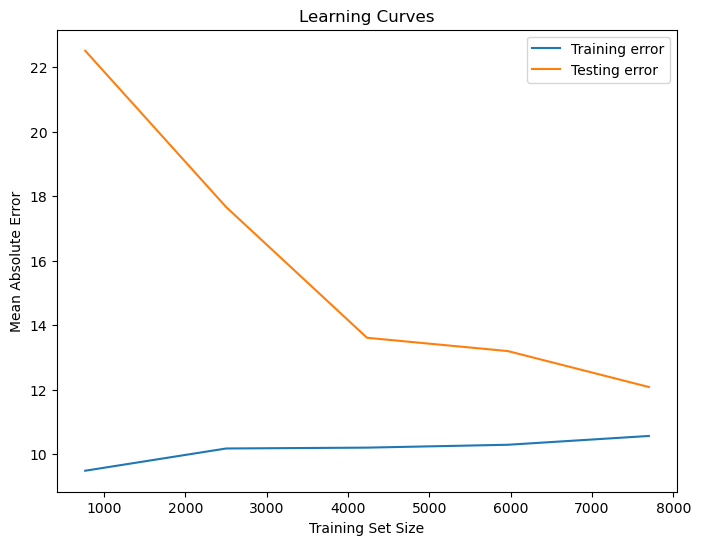

In [293]:
# Run the tuned model
svr_eval_df, svr_pred_xtrain, svr_pred_xtest = run_model(SVR, svr_best_params)

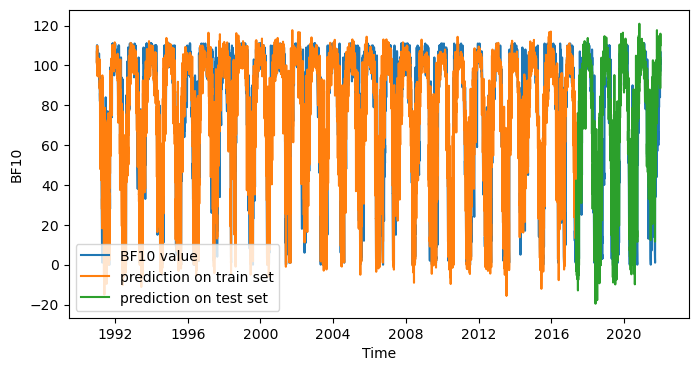

In [294]:
plot_predictions(svr_pred_xtrain, svr_pred_xtest)

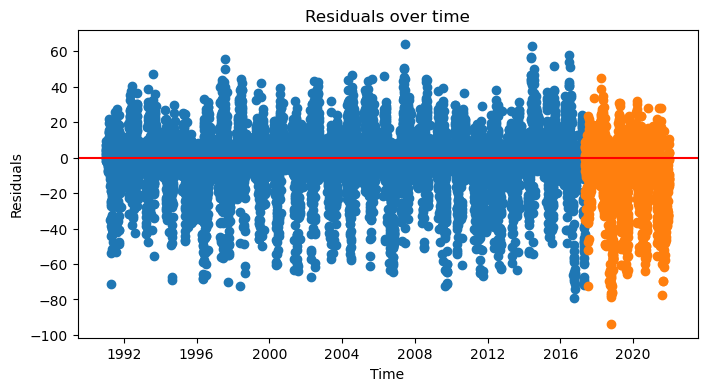

In [295]:
plot_residuals(svr_pred_xtrain, svr_pred_xtest)

# 6- ***LSTM***

## 6-1 Define the Time Window

For the implementation of Long Short-Term Memory (LSTM), a distinct methodology is employed, incorporating the application of a rolling window technique during dataset preparation. Consistent with findings from the Exploratory Data Analysis (EDA) section, the Autocorrelation Function (ACF) plot for the target variable delineates a noteworthy relationship extending up to approximately 80 preceding lags. During the examination of correlated lags for supplementary features, namely 'TS05,' 'RF_TER,' 'VGSL,' and 'TT_TER,' the goal is to identify suitable lag intervals that exploit temporal dependencies.

Analysis of these plots reveals that these features exhibit a robust relationship up to around 80 previous lags, as indicated by the ACF plot. However, the direct association of preceding lags with current timestamps is constrained to the prior 10 lags, as revealed by the Partial Autocorrelation Function (PACF) plots.

Considering the potential escalation in dataset dimensionality associated with an 80-time window for LSTM, a pragmatic choice is made to adopt a 10-time window for the initial analysis. This decision is contingent on achieving satisfactory results, and adjustments to a higher window size can be considered if deemed necessary based on subsequent assessments.

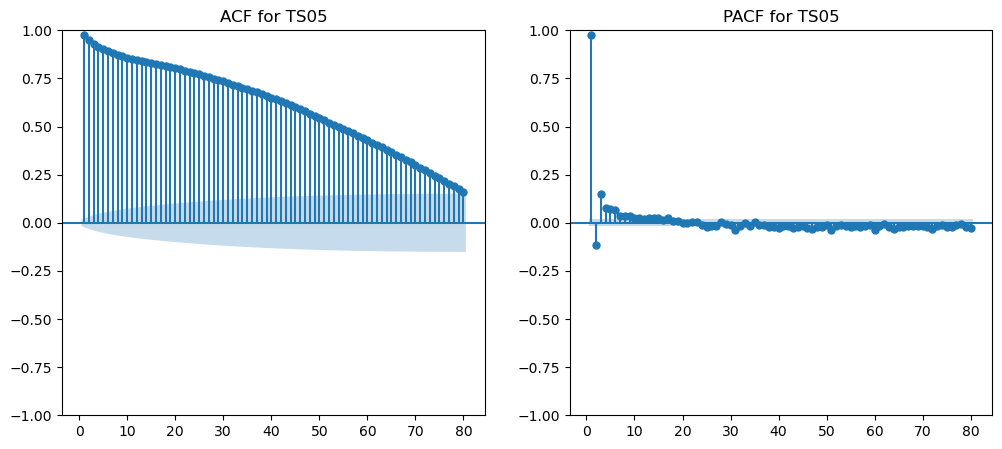

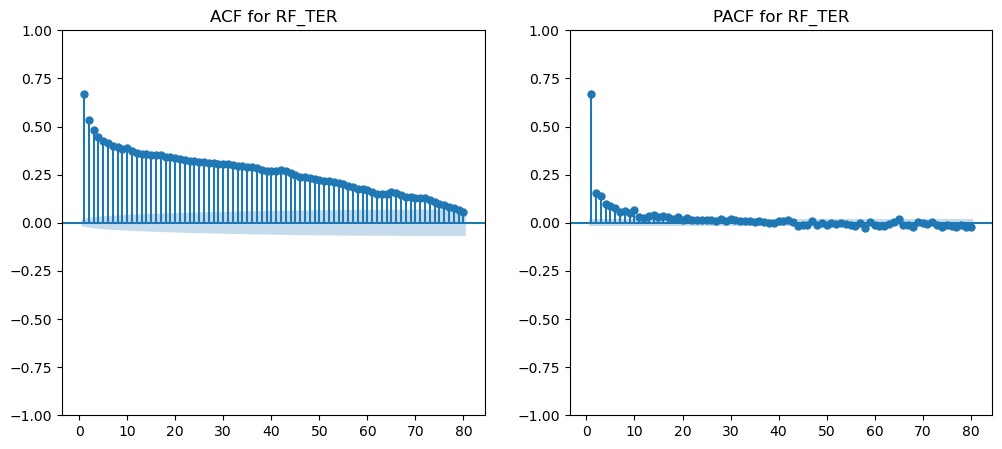

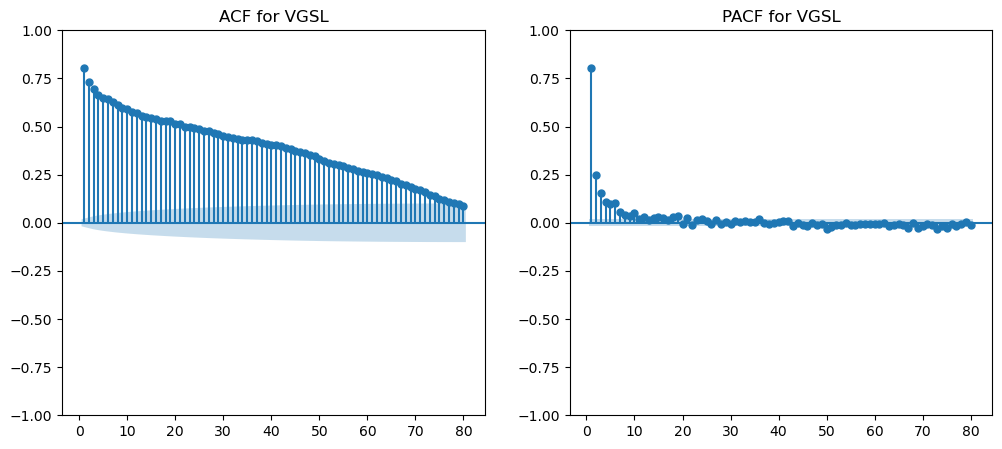

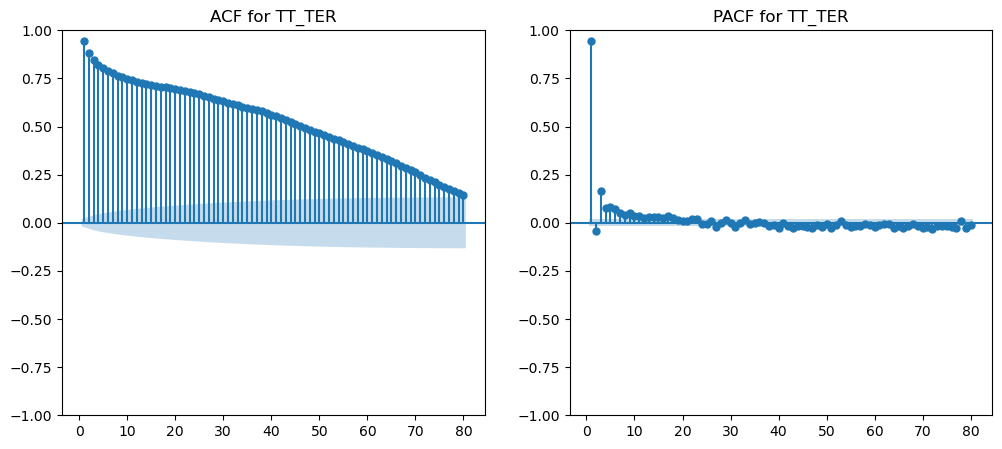

In [58]:
for feature in ['TS05','RF_TER','VGSL','TT_TER']:
    plot_ACF_PACF(final_df, feature, 80)

## 6-2 Data preparation for LSTM

In this phase, the initial step involves the application of a rolling window technique on the 'final_df' dataset to construct a structured input for Long Short-Term Memory (LSTM). This process is executed through the dedicated function named "prepare_time_series_data." Subsequently, the resultant dataset is partitioned into features and target datasets. The features dataset undergoes scaling using the robust scaler to ensure compatibility with LSTM requirements.

To facilitate effective utilization by LSTM, an additional function, "reshape_data_for_lstm," is formulated to structure the features dataset appropriately. This function optimizes the arrangement of features data to align with LSTM model specifications.

Finally, the datasets are segregated into training, validation, and test sets, with an allocation of 80% for training, 10% for validation, and 10% for testing purposes. This partitioning aims to establish a robust framework for model training, validation, and evaluation in a controlled and systematic manner.

In [320]:
# Function to implement rolling window
def prepare_time_series_data(df, target_variable, time_window, prediction_horizon):

    df_prepared = pd.DataFrame()

     # Add lag features for each variable
    for col in df.columns:
        for i in range(1, time_window + 1):
            df_prepared[f'{col}_lag_{i}'] = df[col].shift(i)
    
    # Add the target variable for the prediction horizon
    df_prepared[f'{target_variable}_pred'] = df[target_variable].shift(-prediction_horizon)

    # Drop rows with NaN values introduced by lag features
    df_prepared = df_prepared.dropna()

    return df_prepared


In [321]:
# function to reshape data for LSTM
def reshape_data_for_lstm(X_df, time_steps):
    X_rolled = X_df.values.reshape(X_df.shape[0], time_steps, -1)
    return X_rolled

In [572]:
# Set the time window 
time_steps = 10

# Set prediction horizon
prediction_distance = 30

In [573]:
# Create data set for LSTM 
lstm_df = prepare_time_series_data(final_df, 'BF10', time_window=time_steps, prediction_horizon=prediction_distance)

print(f"\nPrepared DataFrame with shape of => {lstm_df.shape}")
display(lstm_df.head())


Prepared DataFrame with shape of => (11283, 71)


,TS05_lag_1,TS05_lag_2,TS05_lag_3,TS05_lag_4,TS05_lag_5,TS05_lag_6,TS05_lag_7,TS05_lag_8,TS05_lag_9,TS05_lag_10,...,BF10_lag_2,BF10_lag_3,BF10_lag_4,BF10_lag_5,BF10_lag_6,BF10_lag_7,BF10_lag_8,BF10_lag_9,BF10_lag_10,BF10_pred
DATUM,,,,,,,,,,,,,,,,,,,,,
1991-01-11,7.1,5.9,4.5,3.9,3.4,3.7,5.5,6.6,6.3,2.9,...,107.0,110.0,103.0,103.0,109.0,106.0,110.0,110.0,102.0,98.0
1991-01-12,5.5,7.1,5.9,4.5,3.9,3.4,3.7,5.5,6.6,6.3,...,108.0,107.0,110.0,103.0,103.0,109.0,106.0,110.0,110.0,99.0
1991-01-13,3.3,5.5,7.1,5.9,4.5,3.9,3.4,3.7,5.5,6.6,...,103.0,108.0,107.0,110.0,103.0,103.0,109.0,106.0,110.0,99.0
1991-01-14,2.1,3.3,5.5,7.1,5.9,4.5,3.9,3.4,3.7,5.5,...,103.0,103.0,108.0,107.0,110.0,103.0,103.0,109.0,106.0,99.0
1991-01-15,0.5,2.1,3.3,5.5,7.1,5.9,4.5,3.9,3.4,3.7,...,102.0,103.0,103.0,108.0,107.0,110.0,103.0,103.0,109.0,100.0


In [574]:
# Create features and target data sets
lstm_X = lstm_df.drop('BF10_pred', axis=1)
lstm_y = lstm_df['BF10_pred']

print(f"\nLSTM features shape => {lstm_X.shape}")
print(f"\nLSTM target shape  => {lstm_y.shape}")


LSTM features shape => (11283, 70)

LSTM target shape  => (11283,)


In [575]:
# Scale features
lstm_X = scaling(RobustScaler(), lstm_X)

print(f"\nLSTM features shape => {lstm_X.shape}")


LSTM features shape => (11283, 70)


In [576]:
# Reshape features data set for LSTM
lstm_X = reshape_data_for_lstm(lstm_X,time_steps)

print(f"\nLSTM features shape => {lstm_X.shape}")


LSTM features shape => (11283, 10, 7)


In [577]:
# Split data to train, validation, and Test data sets
test_val_size = 0.20

X_train, X_val_test, y_train, y_val_test = train_test_split(lstm_X, lstm_y,
                                                        test_size= test_val_size,
                                                            shuffle=False,
                                                            random_state= 42 )

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test,
                                                        test_size= 0.5,
                                                            shuffle=False,
                                                            random_state= 42 )

shapes = [[X_train.shape,y_train.shape],[X_val.shape,y_val.shape],[X_test.shape,y_test.shape]]
shape =pd.DataFrame(shapes, columns=['X', 'y'], index=['Train', 'Validation', 'Test'])
display(shape)

,X,y
Train,"(9026, 10, 7)","(9026,)"
Validation,"(1128, 10, 7)","(1128,)"
Test,"(1129, 10, 7)","(1129,)"


## 6-3 Running LSTM

Within this section, four essential functions are crafted to orchestrate the tuning, creation, and execution of Long Short-Term Memory (LSTM) models, coupled with the visualization of pertinent metrics to assess the learning process.

1- LSTM Creation Function ("lstm_creator"):
The primary function for constructing LSTM models is designated as "lstm_creator." This function takes three crucial input parameters that necessitate optimization before initiating the training phase. These parameters encompass the number of layers in the LSTM, the dropout percentage within each layer, and the optimizer employed to iteratively minimize the loss function until optimal convergence is achieved.

2- LSTM Tuning Function ("lstm_tuner"):
To fine-tune the LSTM, the "lstm_tuner" function is devised. This function is geared towards optimizing hyperparameters, including the previously mentioned parameters, along with the batch size. It is noteworthy that several other parameters could be subject to tuning, such as learning rate, LSTM cell size, activation functions, and the time window used in data preparation. For this study, the preset values for these parameters are as follows:
- Learning Rate: 0.001
- LSTM Cell Size: 80
- Time Window: 10
- Activation Function: 'relu'

The tuning process is executed with these fixed parameters, and post the final model construction, some of these parameters are individually modified and the model rerun to assess potential significant improvements. For instance, the final model undergoes subsequent runs with altered values for learning rate (0.01), LSTM cell size (60, 50), and time window (15, 5, 3), revealing no substantial improvement.

3- Model Execution and Plotting Function ("run_model"):
The "run_model" function is designed to seamlessly execute both the "lstm_creator" and "lstm_tuner" functions, providing a comprehensive overview of the model's performance. Simultaneously, this function generates visualizations of key metrics, affording a nuanced understanding of the learning process.

In [578]:
learning_rate = 0.001
lstm_cell_size = 80
epochs = 1000
patience = 20

In [579]:
def lstm_creator(layer, dropout, optimizer):
    be.clear_session()
    tf.random.set_seed(42)

    lstm_model = Sequential()

    # LSTM Layer 1
    lstm_model.add( LSTM(lstm_cell_size, activation='relu', return_sequences=False if layer ==1 else True, 
                            input_shape=(time_steps,X_train.shape[2]),
                            kernel_regularizer=l1(0.01)
                        ))  
    lstm_model.add(Dropout(dropout))

    # LSTM layer 2
    if layer == 2:
        lstm_model.add( LSTM(lstm_cell_size//2, activation='relu', 
                                kernel_regularizer=l1(0.01), 
                                return_sequences=False) )
        lstm_model.add(Dropout(dropout))

    # the output layer:
    lstm_model.add(  Dense(1) ) 

    # Define different learning rate for different optimizers
    if optimizer in [RMSprop, Adam]:
        optimizer = optimizer(learning_rate=learning_rate) 
    else:  optimizer = optimizer(learning_rate=learning_rate*10)   

    ## Complile model on loss = mean_absolute_error and metrics = mean_squared_error
    lstm_model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_squared_error'])

    return lstm_model

In [580]:
def lstm_tuner(X_train, X_val, y_train, y_val, params, iter):
    
    # Create grid of all parameters
    parameters_grid = list(itertools.product(*params.values()))

    # select randomly from the grid
    rnd_grid = sample(parameters_grid, k=iter)

    best_score = None
    itteration = 1
    for layer, dropout, optimizer, batch_size in rnd_grid:
        
        print(f'Implementing the {itteration} parameters combination as below:')
        print(f'layer:{layer}; dropout:{dropout}; batch_size:{batch_size}; optimizer:{optimizer}')
        print('#'*10)
        # Create LSTM
        lstm_model = lstm_creator(layer,dropout, optimizer)

        # Define check point
        checkpoint_path = "best_model.hdf5"
        checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
        
        # Define early stoping
        early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=0, mode='min', restore_best_weights=True)

        # Fit the LSTM on Data
        history = lstm_model.fit(x=X_train,
                                y=y_train, 
                                batch_size=batch_size, 
                                validation_data=(X_val,y_val), 
                                epochs=epochs,
                                callbacks=[checkpoint,early_stop],
                                verbose=0,
                                shuffle=False,
                                )
        
        # Save best MAE, best history, best model, and best hyper-parameters
        if best_score == None or  checkpoint.best < best_score:  
            best_score = checkpoint.best
            best_history = history.history
            best_model = load_model('best_model.hdf5')
            best_params = {
                            'layer':layer,
                            'dropout': dropout,
                            'optimizer':optimizer,
                            'batch_size':batch_size,
                            'Best_MAE': best_score}
        itteration += 1      
    #results_df = pd.DataFrame([best_params])
    #display(results_df)
    return best_params, best_history, best_model

        


In [581]:
def plot_train_val(results):
    
    # Plot the MAE of train and validation Datasets
    fig, axs = plt.subplots(1,2 , figsize = (12,6))
    axs[0].plot(results['loss'])
    axs[0].plot(results['val_loss'])
    axs[0].set_title('Model MAE')
    axs[0].set_ylabel('MAE')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'valid'], loc='upper left')

    # Plot the MSE of train and validation Datasets
    axs[1].plot(results['mean_squared_error'])
    axs[1].plot(results['val_mean_squared_error'])
    axs[1].set_title('Model MSE')
    axs[1].set_ylabel('MSE')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'valid'], loc='upper left')
    fig.tight_layout(h_pad=2, w_pad= 2)
    plt.show()

In [582]:
def run_model(X_train,X_val,X_test,y_train,y_val,y_test, params, iter):
  
  
    best_params, best_history, best_model =  lstm_tuner(X_train, X_val, y_train, y_val, params, iter)
    print('#'*100)
    
    print('Final Model Summary ====>')
    print(best_model.summary())
    print('#'*100)

    
    print(f'Best Hyper-parameters ====>')
    hyper_parameters = pd.DataFrame([best_params])
    display(hyper_parameters)  
    print('#'*100)

    # Evaluation on training set
    print("\nEvaluating on training set ====>")
    (MAE, MSE) = best_model.evaluate(X_train, y_train)
    print(f'Mean absolute error= {MAE}\nMean Squared error= {MSE}')

    # Evaluation on test set
    print("\nEvaluating on testing set ====>")
    (MAE, MSE) = best_model.evaluate(X_test, y_test)
    print(f'Mean absolute error= {MAE}\nMean Squared error= {MSE}')
    print('#'*100)

    # plot training process loss and metric
    plot_train_val(best_history) 


    prediction = best_model.predict(X_test)


    # Evaluate model on un-scaled test data set
    print('Final MAE, MSE, and Coeffiient of determination of Model====>')
    mae = mean_absolute_error(y_test,prediction)
    mse = mean_squared_error(y_test,prediction)
    r2 = r2_score(y_test,prediction)

    evaluation = pd.DataFrame({'MAE':[mae],'MSE':[mse], 'R_2': [r2]})
    display(evaluation)
    print('#'*100)
    return (evaluation)


In [583]:
# Set hyper parameters 
layer = [1,2]
dropouts = [0.2, 0.25, 0.3]
optimizer = [RMSprop, Adam, SGD]
batch_size = [64, 128]

Implementing the 1 parameters combination as below:
layer:1; dropout:0.2; batch_size:64; optimizer:<class 'keras.optimizers.optimizer_v2.adam.Adam'>
##########
Implementing the 2 parameters combination as below:
layer:1; dropout:0.2; batch_size:128; optimizer:<class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>
##########
Implementing the 3 parameters combination as below:
layer:1; dropout:0.25; batch_size:64; optimizer:<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>
##########
Implementing the 4 parameters combination as below:
layer:1; dropout:0.2; batch_size:64; optimizer:<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>
##########
Implementing the 5 parameters combination as below:
layer:1; dropout:0.3; batch_size:128; optimizer:<class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>
##########
Implementing the 6 parameters combination as below:
layer:2; dropout:0.3; batch_size:64; optimizer:<class 'keras.optimizers.optimizer_v2.adam.Adam'>
##########
Implemen

,layer,dropout,optimizer,batch_size,Best_MAE
0,1,0.3,<class 'keras.optimizers.optimizer_v2.adam.Adam'>,128,19.259321


####################################################################################################

Evaluating on training set ====>
283/283 [==============================] - 1s 1ms/step - loss: 21.9140 - mean_squared_error: 710.0298
Mean absolute error= 21.91398048400879
Mean Squared error= 710.0298461914062

Evaluating on testing set ====>
36/36 [==============================] - 0s 1ms/step - loss: 20.1698 - mean_squared_error: 646.0261
Mean absolute error= 20.16976547241211
Mean Squared error= 646.026123046875
####################################################################################################


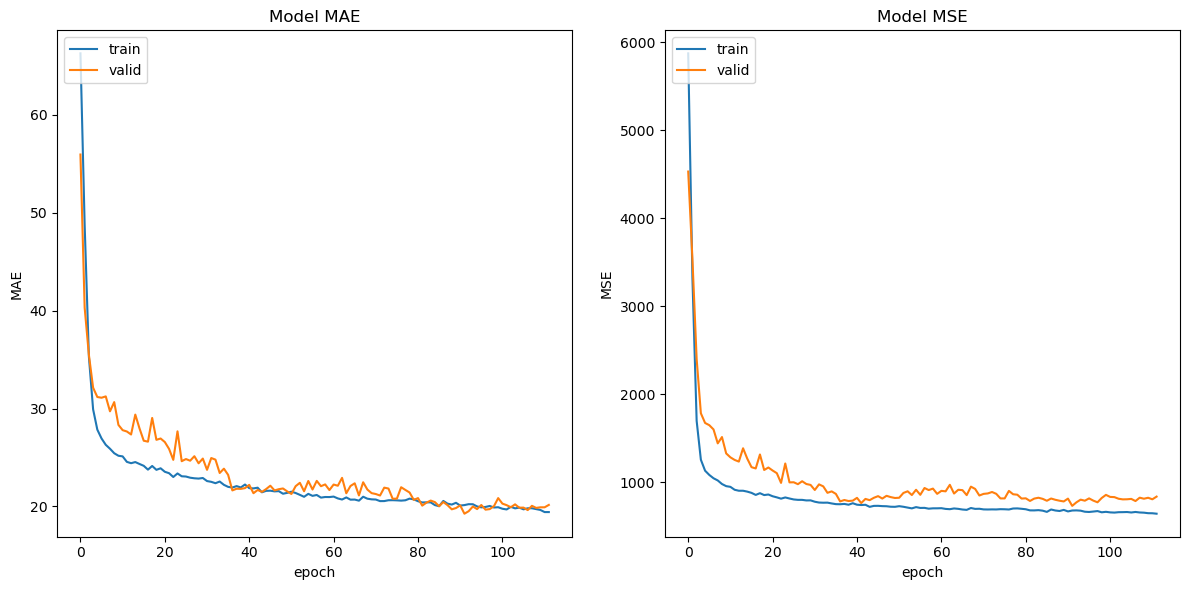

36/36 [==============================] - 0s 1ms/step
Final MAE, MSE, and Coeffiient of determination of Model====>


,MAE,MSE,R_2
0,19.800641,646.026136,0.585165


####################################################################################################


In [584]:
# Set dictionary of hyper-parameter
params = {'layer' : layer,
            'dropouts' : dropouts,
            'optimizer' : optimizer,
            'batch_size' : batch_size
            }

# Define iteration
iteration = 15

# Run model
lstm_result = run_model(X_train,X_val,X_test,y_train,y_val,y_test,
                        params, iteration)

The learning curves, portraying the Mean Absolute Error (MAE) for both the training and validation sets, provide valuable insights into the model's performance with respect to bias and variance. The proximity of the training and test MAE values signifies commendable generalization capabilities, suggesting the model is relatively resilient to both overfitting and underfitting issues. Notably, the convergence of training and test MAE values underscores a balanced model that performs consistently across different datasets.

However, a nuanced observation of the validation set's loss function learning curve reveals a degree of turbulence, indicating potential fluctuations in performance during the validation phase. This behavior warrants further investigation to comprehend the source of variability in the model's response to the validation dataset.

Shifting the focus to the Mean Squared Error (MSE) metric, the learning curve illuminates a distinct pattern. The positioning of the training set's learning curve below that of the validation set suggests a degree of overfitting, wherein the model may be overly adapted to the intricacies of the training data.

# 7- ***Evaluation***

1- Random Forest Regressor (RF) Model:
- MAE (Mean Absolute Error): Achieving the lowest MAE of 15.47, the RF model demonstrates superior accuracy in predicting soil moisture levels. This suggests that the model's predictions are, on average, within a narrow range of the actual values.
- MSE (Mean Squared Error): The RF model also exhibits the lowest MSE at 437.15, indicating precision in capturing the variance and distribution of the soil moisture dataset.
- R² (R-squared): The highest R² value of 0.7309 underscores the model's robust fit to the data, indicating its capability to explain the variability in soil moisture.

2- Support Vector Regressor (SVR) Model:
- MAE: With a MAE of 15.62, the SVR model demonstrates competitive accuracy, closely following the RF model.
- MSE: The SVR model's MSE of 500.64 reflects its ability to maintain precision in predicting soil moisture values.
- R²: An R² value of 0.6918 signifies a strong explanatory power, suggesting the SVR model captures a substantial proportion of the variability in the soil moisture dataset.

3- Long Short-Term Memory (LSTM) Model:
- MAE: The LSTM model, with a MAE of 19.80, exhibits slightly lower accuracy compared to the RF and SVR models.
- MSE: The higher MSE of 646.03 suggests the LSTM model's predictions may deviate more from the actual values, impacting precision.
- R²: An R² value of 0.5852 indicates a moderate fit to the data, implying that the LSTM model captures a substantial but not exhaustive portion of the dataset's variability.

4- Huber Regressor (HR) Model:
- MAE: The HR model, with an MAE of 18.78, demonstrates accuracy comparable to the LSTM model but falls behind RF and SVR.
- MSE: The higher MSE of 625.41 suggests a wider spread of prediction errors in comparison to RF and SVR.
- R²: An R² value of 0.6150 indicates a moderate fit, similar to the LSTM model but below the performance of RF and SVR.

Conclusion:
The evaluation of soil moisture prediction models unveils distinct characteristics in terms of predictive accuracy and model robustness. The Random Forest Regressor emerges as the preeminent model, showcasing the lowest Mean Absolute Error (MAE), Mean Squared Error (MSE), and the highest coefficient of determination (R²). Its exceptional accuracy positions it as a formidable choice, albeit with a caveat—prudent handling of potential overfitting demands careful consideration during model deployment.

The Support Vector Regressor closely trails the Random Forest, demonstrating commendable accuracy and precision. Its competitive performance signifies a balanced compromise between predictive power and generalization capability. The nuanced interplay between accuracy and robustness positions the Support Vector Regressor as a versatile candidate across diverse applications.

In the realm of recurrent neural networks, the Long Short-Term Memory (LSTM) model emerges with distinct attributes. While lagging marginally behind the Random Forest and Support Vector Regressor in predictive accuracy, LSTM distinguishes itself through superior bias-variance management. Its robust performance in handling complex temporal dependencies and mitigating overfitting positions it as an ideal choice in scenarios prioritizing stability and adaptability to new data.

The Huber Regressor, though displaying reasonable performance, falls behind its counterparts in both accuracy and precision. Noteworthy is its susceptibility to overfitting, echoing the importance of vigilant model management in practical implementations.

The selection of the most suitable model necessitates a judicious consideration of the trade-offs between accuracy, interpretability, and generalization capability. Random Forest excels in accuracy but requires careful scrutiny, while Support Vector Regressor provides a reliable compromise. LSTM, with its resilience to overfitting, offers a compelling option for applications requiring adaptability and stability. The nuanced evaluation presented herein aims to guide informed decisions aligned with specific application requirements.

# 8- ***References***

A Deep Conceptual Guide to Mutual Information (https://medium.com/swlh/a-deep-conceptual-guide-to-mutual-information-a5021031fad0)

A Short Guide for Feature Engineering and Feature Selection(https://github.com/ashishpatel26/Amazing-Feature-Engineering/blob/master/A%20Short%20Guide%20for%20Feature%20Engineering%20and%20Feature%20Selection.md)

Feature selection in machine learning with Python (https://www.blog.trainindata.com/feature-selection-machine-learning-with-python/)

How to Group Pandas DataFrame By Date and Tim(https://www.geeksforgeeks.org/how-to-group-pandas-dataframe-by-date-and-time/)

Keras API reference / Optimizers(https://keras.io/api/optimizers/)

Keras API reference / Callbacks API / ModelCheckpoint (https://keras.io/api/callbacks/model_checkpoint/)

Keras API reference / Callbacks API / EarlyStopping(https://keras.io/api/callbacks/early_stopping/)

Metrics and scoring: quantifying the quality of predictions(https://scikit-learn.org/stable/modules/model_evaluation.html)

pandas.date_range (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html)

pandas.plotting.parallel_coordinates (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.parallel_coordinates.html)

Select Features for Machine Learning Model with Mutual Information (https://towardsdatascience.com/select-features-for-machine-learning-model-with-mutual-information-534fe387d5c8)

sklearn.preprocessing.RobustScaler (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)

sklearn.feature_selection.mutual_info_regression (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html)

sklearn.linear_model.HuberRegressor(https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html)

sklearn.svm.SVR(https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

sklearn.ensemble.RandomForestRegressor(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Visualize data using Parallel Coordinates Plot (https://www.analyticsvidhya.com/blog/2021/11/visualize-data-using-parallel-coordinates-plot/)

What is Mutual Information? (https://quantdare.com/what-is-mutual-information/)